# FIT5196 Data Wrangling - S2 2016
 
## Assessment 3 - Data Integration and Reshaping
 
Filename: International_Disasters_data_integration.ipynb
 
Author: Lynn Miller
 
Date: 18-Sep-2016
 
Version: 1.0
 
Language: Python 2.7.12 and Jupyter notebook Anaconda 2 version 4.1.1 

Libraries used:
- `pandas (version 0.18.1)`: for data frames
- `numpy (version 1.11.1)`: for numpy arrays
- `datetime`: for datetime data types
- `re (version 2.2.1)`: for regular expressions
- `math`: for log functions
- `difflib`: for string matching
- `shapefile (version 1.2.3)`: for plotting maps using shapefiles
- `matplotlib (version 1.5.1)`: for plotting methods

Input files:
- Disasters.csv - the disasters dataset
- Disasters_Recent.csv - the recent disasters dataset
- Country_info.csv - names and ISO codes for countries
- world_countries_boundary_file_world_2002 - shape file for countries

Output files:
- Disasters_data_integrated.csv - contains the integrated data
 
## Introduction

This code is developed to integrate the disasters dataset with the recent disasters dataset:
 
**Task 1: Data Integration -** Identifies and fixes some common data problems.
- Step 1: Schema Conflicts: Inspect the data to find schema conflicts and resolve these conflicts
- Step 2: Merging: Create a global schema, implement the semantic mapping and merge the data
- Step 3: Data Conflicts: Detect and resolve inconsistencies and duplication and create a global key

**Task 2: Mash up map -** Plots the number of disasters between 1980 and 2015 for each country, using a sample of 80% of the integrated data

## Resources Used

- Online Python documentation - https://docs.python.org/2/index.html
- Online Pandas documentation - http://pandas.pydata.org/pandas-docs/stable/index.html
- Online difflib documentation - https://docs.python.org/2/library/difflib.html
- Online matplotlib documentation - http://matplotlib.org/contents.html
- Plotly - https://plot.ly/matplotlib/subplots/ for information on matplotlib gridspec
- Stackexchange answer from http://stackoverflow.com/questions/15908371/matplotlib-colorbars-and-its-text-labels for how to discretise matplotlib colorbars
- EM-DAT: The International Disaster Database website - http://www.emdat.be/ for information about Disaster Groups/Subgroups 
- Code provided in tutorial 6 for plotting shapefiles and colouring countries

## Initialisation 

Import the libraries used:

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import re
import math
import difflib
import shapefile

import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
from matplotlib import gridspec

%matplotlib inline

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('expand_frame_repr', False)

## Task 1: Integration between S1 and S2 

### Load the Data

#### Load the S1 dataset (disasters)

Read the file, converting Start and End to dates

In [3]:
S1 = pd.read_csv("Disasters.csv",index_col=0,dayfirst=True,parse_dates=["Start","End"])

# Display the column types
S1.dtypes

Start                    datetime64[ns]
End                      datetime64[ns]
Country                          object
Location                         object
Type                             object
Sub_Type                         object
Names                            object
Killed                          float64
Affected                        float64
International support           float64
dtype: object

Describe the string and date columns

In [4]:
S1.describe(include=["object","datetime"])

,Start,End,Country,Location,Type,Sub_Type,Names
count,13694,13694,13694,12020,13694,11914,4444
unique,1006,1012,215,10226,15,43,2187
top,2007-08-01 00:00:00,2007-08-01 00:00:00,China,North,transport accident,road,Coal mine
freq,77,75,1065,51,3525,1563,284
first,1900-01-01 00:00:00,1900-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2008-12-01 00:00:00,2009-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN


Describe the numeric columns, excluding NaNs

In [5]:
S1[["Killed","Affected","International support"]].apply(lambda x: x.dropna().describe())

,Killed,Affected,International support
count,11098.000,8517.000,6838.000
mean,916.870,453540.708,1014.797
std,40596.889,5962457.922,446.389
min,1.000,1.000,0.000
25%,12.000,51.000,696.652
50%,24.000,795.000,1076.298
75%,55.000,15000.000,1324.181
max,3700000.000,300000000.000,2801.093


Some points to note about the S1 dataset:
- There are 13694 records
- Start and End are all valid dates
- Location and Sub_Type have a few Nans, Names has a lot of NaNs
- Each of Killed, Affected and International support has a few NaNs
- Neither Killed nor Affected have any zero values - so zeroes may have been converted to NaNs at some point.
- International support has zero values and NaNs.
- Unit for International support is unclear - the values seem too low to be US\$1000 units, so may be US\$1000,000 units.
- The distribution of International support values is very narrow compared with the distribution for Killed and Affected.

Display the first few records

In [6]:
S1.head(10)

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,International support
0,1965-06-01,1965-06-01,Japan,NaN,storm,tropical cyclone,Dinah,61.000,30000.000,1934.944
1,2004-09-01,2004-09-01,Grenada,NaN,storm,tropical cyclone,Ivan,39.000,60000.000,1090.830
2,1995-03-01,1995-03-01,Russia,Kalmoukie:Daghestan (Mer ...,transport accident,water,NaN,52.000,nan,nan
3,1983-02-01,1983-02-01,Cuba,Santiago de Cuba:Pinar d ...,flood,NaN,NaN,15.000,164575.000,905.275
4,1996-07-01,1996-07-01,Russia,Volgorgrad,industrial accident,gas leak,Oil refinery,nan,nan,nan
5,2003-06-01,2003-06-01,Turkey,Kayseri,miscellaneous accident,explosion,Dormitory of a school,10.000,13.000,824.806
6,2003-02-01,2003-02-01,Pakistan,Baluchistan:Sindh:North ...,storm,NaN,NaN,51.000,2557.000,992.690
7,1986-08-01,1986-08-01,Honduras,Northeast Honduras/Mosqui ...,flood,NaN,NaN,nan,30000.000,nan
8,2007-10-01,2007-10-01,Colombia,Near Suarez (Cauca),industrial accident,collapse,Cold mine,22.000,24.000,888.882
9,2002-09-01,2002-09-01,Senegal,Au large de la Gambie,transport accident,water,Ferry 'Joola',1200.000,nan,nan


#### Load the S2 Dataset (Recent Disasters)

The headers don't load correctly using read_csv, so read in the header record separately and create a list of column names for read_csv to use

In [7]:
# Read the header record, specifying the correct record delimiter
S2file = open("Disasters_Recent.csv","rU")
S2header = S2file.readline()
S2file.close()

# Split head record into column names
S2header=re.split(r"[,;]\s*",S2header)
# Remove the null string element from the column name list
S2header.remove('')

# Read the recent disasters dataset, skipping the header records and specifying column names
S2 = pd.read_csv("Disasters_Recent.csv", skiprows=1, names=S2header)

# Display the column types
S2.dtypes

year                       int64
disaster type             object
Country iso               object
Country name              object
disaster group            object
disaster subgroup         object
disaster subtype          object
continent                 object
region                    object
occurrence                 int64
Total deaths               int64
Affected                   int64
Injured                    int64
Homeless                   int64
Total affected             int64
Total damage               int64
International support    float64
dtype: object

Describe the string columns

In [8]:
S2.describe(include=["object"])

,disaster type,Country iso,Country name,disaster group,disaster subgroup,disaster subtype,continent,region
count,4503,4503,4503,4503,4503,4503,4503,4503
unique,13,208,208,1,6,25,5,22
top,Flood,USA,United States of America (the),Natural,Hydrological,Riverine flood,Asia,Southern Asia
freq,1609,150,150,4503,1828,1080,1411,460


There are no NaNs, so missing values may be represented by another values

Describe the numeric columns

In [9]:
S2.describe()

,year,occurrence,Total deaths,Affected,Injured,Homeless,Total affected,Total damage,International support
count,4503.000,4503.000,4503.000,4503.000,4503.000,4503.000,4503.000,4503.000,4503.000
mean,2006.863,1.487,283.108,700899.402,988.512,7934.043,709821.957,406030.315,327835.509
std,4.590,1.220,5098.935,6991749.569,28532.634,113547.783,7003914.881,4557971.274,389072.551
min,2000.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2003.000,1.000,0.000,0.000,0.000,0.000,83.500,0.000,0.000
50%,2007.000,1.000,7.000,1300.000,0.000,0.000,2272.000,0.000,195737.290
75%,2011.000,2.000,34.000,26779.000,4.000,0.000,32100.000,5136.500,516868.785
max,2015.000,17.000,222570.000,300000000.000,1800000.000,5000000.000,300000000.000,210000000.000,3044471.500


Some points to note about the S2 dataset:
- There are 4503 records
- There are no NaNs in any column, so missing values may be represented by another value
- Most of the numeric columns have a lot of zeros, so missing values may be represented by 0's here. If so there appears no way to distinguish between missing values and real 0's.

Display the first few records

In [10]:
S2.head(10)

,year,disaster type,Country iso,Country name,disaster group,disaster subgroup,disaster subtype,continent,region,occurrence,Total deaths,Affected,Injured,Homeless,Total affected,Total damage,International support
0,2000,Drought,AFG,Afghanistan,Natural,Climatological,Drought,Asia,Southern Asia,1,37,2580000,0,0,2580000,50,122245.870
1,2000,Drought,ARM,Armenia,Natural,Climatological,Drought,Asia,Western Asia,1,0,297000,0,0,297000,100000,5400.000
2,2000,Drought,AZE,Azerbaijan,Natural,Climatological,Drought,Asia,Western Asia,1,0,0,0,0,0,100000,0.000
3,2000,Drought,BOL,Bolivia (Plurinational State of),Natural,Climatological,Drought,Americas,South America,1,0,20000,0,0,20000,0,0.000
4,2000,Drought,BIH,Bosnia and Herzegovina,Natural,Climatological,Drought,Europe,Southern Europe,1,0,0,0,0,0,158000,0.000
5,2000,Drought,BGR,Bulgaria,Natural,Climatological,Drought,Europe,Eastern Europe,1,0,0,0,0,0,0,0.000
6,2000,Drought,CHN,China,Natural,Climatological,Drought,Asia,Eastern Asia,3,0,20000000,0,0,20000000,796115,23500.000
7,2000,Drought,CUB,Cuba,Natural,Climatological,Drought,Americas,Caribbean,1,0,0,0,0,0,0,0.000
8,2000,Drought,CYP,Cyprus,Natural,Climatological,Drought,Asia,Western Asia,1,0,0,0,0,0,0,0.000
9,2000,Drought,GEO,Georgia,Natural,Climatological,Drought,Asia,Western Asia,1,0,696000,0,0,696000,200000,2300.000


### Step 1: Schema Conflicts

Inspect the S1 and S2 schemas for schema conflicts. Data conflicts will also be resolved in the section.

#### Disaster Dates

The disaster dates are represented as a Start/End date in S1, but only by the year in S2. S1.Start and S1.End are datetime datatypes and S2.year is integer datatype.

Before resolving this issue, find out more about these attributes.

1\. Check the distribution of values in each column

In [11]:
# Print summary of each attribute representing a date
print "Date representation in S1 and S2\n================================"
print "\nS1 Start\n--------\n", S1.Start.describe()
print "\nS1 End\n------\n", S1.End.describe()
print "\nS2 Year\n-------\n", S2.year.describe()

Date representation in S1 and S2

S1 Start
--------
count                   13694
unique                   1006
top       2007-08-01 00:00:00
freq                       77
first     1900-01-01 00:00:00
last      2008-12-01 00:00:00
Name: Start, dtype: object

S1 End
------
count                   13694
unique                   1012
top       2007-08-01 00:00:00
freq                       75
first     1900-01-01 00:00:00
last      2009-10-01 00:00:00
Name: End, dtype: object

S2 Year
-------
count   4503.000
mean    2006.863
std        4.590
min     2000.000
25%     2003.000
50%     2007.000
75%     2011.000
max     2015.000
Name: year, dtype: float64


S1 dates are from 1900 to 2008/2009 and S2 dates are from 2000 to 2015 as expected.

2\. S1 seems to have a lot of dates of the first of the month, check the distribution of months and days.

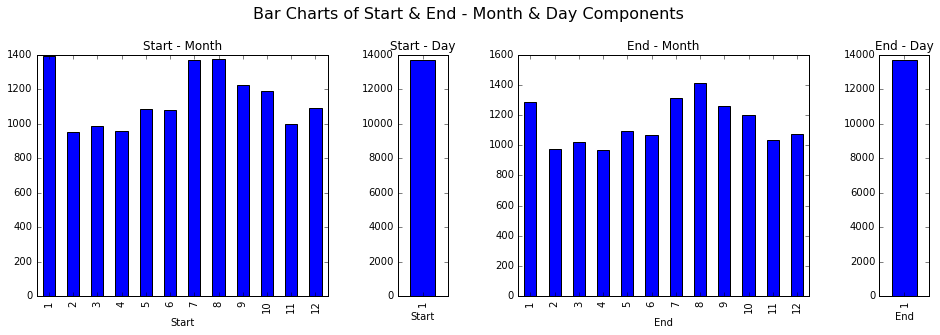

In [12]:
# Create a figure
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(15, 15)
ax1 = fig.add_subplot(gs[1:14,0:5])
ax2 = fig.add_subplot(gs[1:14,6])
ax3 = fig.add_subplot(gs[1:14,8:13])
ax4 = fig.add_subplot(gs[1:14,14])

# Plot the month conponent of Start
S1.groupby(S1.Start.apply(lambda x: x.month))["Start"].count().plot.bar(ax=ax1) 
# Plot the day conponent of Start
S1.groupby(S1.Start.apply(lambda x: x.day))["Start"].count().plot.bar(ax=ax2) 
# Plot the month conponent of End
S1.groupby(S1.End.apply(lambda x: x.month))["Start"].count().plot.bar(ax=ax3) 
# Plot the day conponent of End
S1.groupby(S1.End.apply(lambda x: x.day))["Start"].count().plot.bar(ax=ax4) 

# Set the title and axis labels
fig.suptitle("Bar Charts of Start & End - Month & Day Components", fontsize=16)
ax1.set_title("Start - Month")
ax2.set_title("Start - Day")
ax3.set_title("End - Month")
ax4.set_title("End - Day")

plt.show()

Dates in S1 are all for the first of the month. Months are distributed more or less as expected. In other words, Start and End represent months, not dates.

Now resolve the original conflict.

**Conflict**: Dates are represented differently in S1 and S2.  
**Resolution**: In S1, create a new "Year" attribute that contains the year component extracted from Start.

In [13]:
# S1 - Add a new "Year" attribute - extract the year from "Start"
S1["Year"] = S1.Start.apply(lambda x: x.year)

# Check the Year data type
print S1.Year.dtype
# Describe the Year attribute
S1.Year.describe()

int64


count   13694.000
mean     1991.584
std        17.161
min      1900.000
25%      1987.000
50%      1997.000
75%      2003.000
max      2008.000
Name: Year, dtype: float64

#### Disaster Type Hierarchy

S1 and S2 contain a number of columns that are used to describe the type of disaster.
- S1 has Type, Sub_Type
- S2 has disaster group, disaster subgroup, disaster type, disaster subtype

Investigate the following:
- Which attributes in S1 and S2 match?
- Do the S1 columns form a hierarchy?
- Do the S2 columns form a hierarchy?

S1.Type and S2."disaster type" are probably the same attribute - compare the values for each

In [14]:
# List the disaster type domains in both S1 and S2
print "S1 Type values"
print "--------------"
print S1.groupby("Type")["Type"].count()
print "\nS2 disaster type values"
print "-----------------------"
print S2.groupby("disaster type")["disaster type"].count()

S1 Type values
--------------
Type
complex disasters                   2
drought                            78
earthquake (seismic activity)     874
epidemic                          899
extreme temperature               291
flood                            2736
industrial accident               878
insect infestation                 46
mass movement dry                  43
mass movement wet                 409
miscellaneous accident            897
storm                            2593
transport accident               3525
volcano                           157
wildfire                          266
Name: Type, dtype: int64

S2 disaster type values
-----------------------
disaster type
Animal accident            1
Drought                  266
Earthquake               268
Epidemic                 595
Extreme temperature      328
Flood                   1609
Impact                     1
Insect infestation        19
Landslide                219
Mass movement (dry)       12
Storm            

There are quite a few matches (ignoring case), and each attribute has a similar number of values. These are the same attributes, but have slightly different domains.

S1.Sub_Type and S2."disaster subtype" are probably the same attribute - compare the values for each

In [15]:
# List the disaster subtype domain values in both S1 and S2
print "S1 Sub_Type values"
print "--------------"
print S1.fillna("NaN").groupby("Sub_Type")["Sub_Type"].count()
print "\nS2 disaster subtype values"
print "-----------------------"
print S2.groupby("disaster subtype")["disaster subtype"].count()

S1 Sub_Type values
--------------
Sub_Type
NaN                                     1780
air                                      732
avalanche                                 70
bacterial infectious diseases            471
bush/brush fire                            1
chemical spill                            50
cold wave                                136
collapse                                 249
debris flow                                1
drought                                   78
earthquake (ground shaking)              842
explosion                                605
extratropical cyclone                     45
extratropical cyclone (winter storm)       1
extreme winter conditions                 34
famine                                     1
fire                                     569
flash flood                              327
forest fire                              189
gas leak                                  37
general flood                           1376
general floo

These don't match quite as well as S1.Type and S2."disaster type" did, but there is clearly a lot in common between the two lists. Again, these are the same attribute but have slightly different domains.

The above also shows that missing values in S1 are represented as NaNs 

Investigate whether or not the S1 Type and Sub_Type columns form a hierarchy.

In [16]:
print "Number of distinct Types:", len(S1.Type.unique())
print "Number of distinct Sub_Types:", len(S1.Sub_Type.unique())
print "Number of Type/Sub_Type combinations:", len(S1.groupby(["Type","Sub_Type"]))

# Display all the combinations of Type and Subtype
print "\n", S1.fillna("NaN").groupby(["Type","Sub_Type"]).Type.count()

Number of distinct Types: 15
Number of distinct Sub_Types: 44
Number of Type/Sub_Type combinations: 59

Type                           Sub_Type                            
complex disasters              NaN                                        1
                               famine                                     1
drought                        drought                                   78
earthquake (seismic activity)  NaN                                        2
                               earthquake (ground shaking)              842
                               tsunami                                   30
epidemic                       NaN                                      109
                               bacterial infectious diseases            471
                               parasitic infectious diseases             43
                               viral infectious diseases                276
extreme temperature            cold wave                            

Although some records are missing the Sub_Type, and some Sub_Types are common between two Types, there appears to be a hierarchy here.

Investigate whether or not the S2 disaster group, disaster subgroup, disaster type and disaster subtype columns form a hierarchy.

In [17]:
print "Number of distinct disaster groups:", len(S2["disaster group"].unique())
print "Number of distinct disaster subgroups:", len(S2["disaster subgroup"].unique())
print "Number of distinct disaster types:", len(S2["disaster type"].unique())
print "Number of distinct disaster subtypes:", len(S2["disaster subtype"].unique())
print "Number of Type/Sub_Type combinations:", \
      len(S2.groupby(["disaster group","disaster subgroup","disaster type","disaster subtype"]))
    
# Display the combinations of "disaster group","disaster subgroup","disaster type" and "disaster subtype"
print "\n", S2.groupby(["disaster group","disaster subgroup","disaster type","disaster subtype"]).year.count()

Number of distinct disaster groups: 1
Number of distinct disaster subgroups: 6
Number of distinct disaster types: 13
Number of distinct disaster subtypes: 25
Number of Type/Sub_Type combinations: 39

disaster group  disaster subgroup  disaster type         disaster subtype              
Natural         Biological         Animal accident       --                                   1
                                   Epidemic              --                                  59
                                                         Bacterial disease                  273
                                                         Parasitic disease                   15
                                                         Viral disease                      248
                                   Insect infestation    --                                   3
                                                         Locust                              16
                Climatological     Droug

From this it can be seen that:
- There is only one disaster group - Natural. So S2 only has natural disasters.
 - Some of the disaster types in S1 (e.g. "industrial accident") are clearly not natural disasters.
 - As this attribute has only a single value, there doesn't seem to be much point keeping it.
- Disaster group - disaster subgroup - disaster type form a strict hierarchy
- Disaster subtype
 - has missing values across many of the disaster types
 - has values that are common to both "Mass movement (dry)" and "Landslide"  
 - but is obviously also part of the hierarchy

**Findings and Conflicts**

Summary of the conflicts and other findings about the disaster type and related attributes:
- S1.Type and S2."Disaster type" are the same attribute but have different domains
- S1.Sub_Type and S2."Disaster subtype" are the same attribute but have different domains
- Missing values are represented by NaN in S1.Sub_Type but by "--" in S2."disaster subtype"
- S1 and S2 have different levels of aggregation across the disaster type hierarchies:
 - S1 has the hierarchy: Type - Sub_Type
 - S2 has the hierarchy: disaster group - disaster subgroup - disaster type - disaster subtype
- S2."Disaster subgroup" has no equivalent attribute in S1, but for most S1 Types values could be derived by matching to the equivalent S2 disaster type and then looking up the disaster sub-group.
- S2."Disaster group" has the single value "Natural" implying S2 has only natural disasters. S1 has both natural and non-natural disasters.

**Resolution**

The above conflicts will be resolved using the following methods :
1. Map S1.Type to S2."disaster type" to create a global domain of disaster types. The global domain will also contain values unique to S1 or S2. 
 - Update S1.Type values to match the global domain values
2. Add a column for the "Disaster subgroup" to S1, and derive values for this by matching Types to S2 "disaster types".
3. Add a new disaster subgroup value for the non-natural disaster types that occur in S1 only.
4. S2."disaster group" is redundant and will not be included in the merged data.
5. Map S1.Sub_Type to S2."disaster subtype" to create a global domain of disaster subtypes. The global domain will also contain values unique to S1 or S2.
 - Update NaN in S1.Sub_Type to "--"
 - Update S1.Sub_Type values to match the global domain values

##### Conflicts 1, 2 and 3: Mismatching Disaster Types and Missing Disaster Subgroup from S1

A global domain of disaster types is created. Where possible, the S2 disaster types are used as these match the disaster types on the EM-DAT website (http://www.emdat.be/). 

The Type attribute in S1 is matched to the "Disaster type" attribute in the global domain. The attibutes are matched using difflib.get_close_matches and finding the closest match that starts with the same letter. One pair (mass movement wet and Landslide) is manually matched as string matching fails to match these. Any S1 Types that cannot be matched will be added to the global domain.

S1.Type values are updated to the matched global domain value.

A new attribute of Subgroup is added to S1, this is equivalent to "Disaster subgroup" in S2. It will be derived from the matched Type/Disaster Type, where these have been matched. New Subgroups of "Complex disasters" and "Technological" (as used on the EM-DAT website) will be used where there is no match between the S1 Type and the S2 Disaster types.

Create the global domain of disaster types

In [18]:
# Extract a list of unique types from S1
S1type = pd.DataFrame(S1.Type.unique(),columns=["Type"])
# Add a column for the global domain values
S1type["SDtype"] = ""

# Extract a list of unique types from S1
S2type = S2[["disaster type","disaster subgroup"]].drop_duplicates()

# Try to find a match for each S1 Type
for i in range(S1type.SDtype.count()):
    # Capitalize the type to be matched
    S1temp = S1type.loc[i, "Type"].capitalize()
    # Find the close matches
    matches = difflib.get_close_matches(S1temp, S2type["disaster type"], cutoff=0.5)
    # If some matches are found ...
    if len(matches) != 0:
        for m in iter(matches):
            # Find the closest match that starts with the same letter
            if S1temp[0] == m[0]:
                # match found - save this match and move on to the next Type
                S1type.loc[i,"SDtype"] = m
                break

# Manual match for "mass movement wet" to "Landslide"      
S1type.loc[S1type.Type=="mass movement wet","SDtype"] = "Landslide"

# Set the global type for type values unique to S1
S1type.loc[S1type.SDtype == "","SDtype"] = S1type.loc[S1type.SDtype == "","Type"].apply(lambda x: x.capitalize())

# Merge S1type and S2type to get the disaster subgroups
S1type = S1type.merge(S2type, how="left", left_on = "SDtype", right_on = "disaster type").drop("disaster type", axis=1)

# Add disaster subgroups for type values unique to S1
S1type.loc[S1type.Type == "complex disasters","disaster subgroup"] = "Complex disasters"
S1type.loc[S1type["disaster subgroup"].isnull(),"disaster subgroup"] = "Technological"

# Display the matched records
S1type                

,Type,SDtype,disaster subgroup
0,storm,Storm,Meteorological
1,transport accident,Transport accident,Technological
2,flood,Flood,Hydrological
3,industrial accident,Industrial accident,Technological
4,miscellaneous accident,Miscellaneous accident,Technological
5,earthquake (seismic activity),Earthquake,Geophysical
6,volcano,Volcanic activity,Geophysical
7,mass movement wet,Landslide,Hydrological
8,epidemic,Epidemic,Biological
9,extreme temperature,Extreme temperature,Meteorological


Update S1.Type to match the disaster type global domain values and add the Subgroup attribute to S1

In [19]:
# Update the S1 disaster types to the common values
S1[["Type","Subgroup"]] = S1.merge(S1type, how="left", on="Type")[["SDtype","disaster subgroup"]]

# Check the results - display the counts of records by Type and Subgroup
print S1.groupby(["Type","Subgroup"])["Type"].count()
# and describe these columns
S1[["Type","Subgroup"]].describe()

Type                    Subgroup         
Complex disasters       Complex disasters       2
Drought                 Climatological         78
Earthquake              Geophysical           874
Epidemic                Biological            899
Extreme temperature     Meteorological        291
Flood                   Hydrological         2736
Industrial accident     Technological         878
Insect infestation      Biological             46
Landslide               Hydrological          409
Mass movement (dry)     Geophysical            43
Miscellaneous accident  Technological         897
Storm                   Meteorological       2593
Transport accident      Technological        3525
Volcanic activity       Geophysical           157
Wildfire                Climatological        266
Name: Type, dtype: int64


,Type,Subgroup
count,13694,13694
unique,15,7
top,Transport accident,Technological
freq,3525,5300


##### Conflict 4: S2 "disaster group" is redundant

This will be addressed when the two sources are merged.

##### Conflict 5: Mismatching Disaster Subtype Domains

NaNs in S1.Sub_Type are changed to "--" to match the representation of missing values in S2.

A global domain of disaster subtypes is created. Where possible, the S2 disaster subtypes are used as these match the disaster subtypes on the EM-DAT website (http://www.emdat.be/). 

The Sub_Type attribute in S1 is matched to the "Disaster subtype" attribute in the global domain. The attibutes are matched using difflib.get_close_matches and finding the closest match that starts with the same letter. If no matches start with the same letter then the closest match is used. A small number of pairs are manually matched as string matching fails to match these. Any S1 Sub_Types that cannot be matched will be added to the global domain.

S1.Sub_Type values are updated to the matched global domain value.

In [20]:
# Update nulls in S1 to "--"
S1.loc[S1.Sub_Type.isnull(),"Sub_Type"] = "--"

Create the global domain for disaster subtype

In [21]:
# Extract a list of unique sub-types from S1
S1subtype = pd.DataFrame(S1.groupby(["Type","Sub_Type"]).count().index.values.tolist(), columns=["Type","Sub_Type"])
# Add a column for the global domain values
S1subtype["SDsubtype"] = ""

# Extract a list of unique sub-types from S2
S2subtype = pd.DataFrame(S2.groupby(["disaster type","disaster subtype"]).count().index.values.tolist(),
                         columns=["disaster type","disaster subtype"])

for i in range(S1subtype.SDsubtype.count()):
    # Capitalize the sub-type to be matched
    S1temp = S1subtype.loc[i, "Sub_Type"].capitalize()
    # Extract all S2 subtypes for this disaster type
    S2temp = S2subtype.loc[S2subtype["disaster type"] == S1subtype.Type[i] ,"disaster subtype"]
    # Find the close matches
    matches = difflib.get_close_matches(S1temp, S2temp)
    # If some matches are found ...
    if len(matches) != 0:
        # Save the closest match
        S1subtype.loc[i,"SDsubtype"] = matches[0]  
        for m in iter(matches):
            # Find the closest match that starts with the same letter
            if S1temp[0] == m[0]:
                # match found - save this match and move on to the next Type
                S1subtype.loc[i,"SDsubtype"] = m
                break

# Manually match some problematic sub-types                
S1subtype.loc[S1subtype.Sub_Type=="general flood","SDsubtype"] = "Riverine flood"
S1subtype.loc[S1subtype.Sub_Type=="general flood/mudslide","SDsubtype"] = "Riverine flood"
S1subtype.loc[S1subtype.Sub_Type=="local storm","SDsubtype"] = "Convective storm"
S1subtype.loc[S1subtype.Sub_Type=="earthquake (ground shaking)","SDsubtype"] = "Ground movement" 
S1subtype.loc[S1subtype.Sub_Type=="bush/brush fire","SDsubtype"] = "Land fire (Brush, Bush, Pastur" 
S1subtype.loc[S1subtype.Sub_Type=="scrub/grassland fire","SDsubtype"] = "Land fire (Brush, Bush, Pastur" 

# For anything that remains unmatched, use the S1 subtype - capitalised and truncated at the first special character
S1subtype.loc[S1subtype.SDsubtype == "","SDsubtype"] = S1subtype.loc[S1subtype.SDsubtype == "","Sub_Type"]. \
                                                       str.extract(r"^(.*?)(?: *[/\(]|$)").apply(lambda x: x.capitalize())

# Display the matched records
S1subtype

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:37: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


,Type,Sub_Type,SDsubtype
0,Complex disasters,--,--
1,Complex disasters,famine,Famine
2,Drought,drought,Drought
3,Earthquake,--,--
4,Earthquake,earthquake (ground shaking),Ground movement
5,Earthquake,tsunami,Tsunami
6,Epidemic,--,--
7,Epidemic,bacterial infectious diseases,Bacterial disease
8,Epidemic,parasitic infectious diseases,Parasitic disease
9,Epidemic,viral infectious diseases,Viral disease


Update S1.Sub_Type to match the global domain values

In [22]:
# Update the S1 disaster sub-types to the common values
S1["Sub_Type"] = S1.merge(S1subtype[["Type","Sub_Type","SDsubtype"]], how="left").SDsubtype

# Check the results
S1.groupby(["Type","Sub_Type"])["Sub_Type"].count()

Type                    Sub_Type                      
Complex disasters       --                                   1
                        Famine                               1
Drought                 Drought                             78
Earthquake              --                                   2
                        Ground movement                    842
                        Tsunami                             30
Epidemic                --                                 109
                        Bacterial disease                  471
                        Parasitic disease                   43
                        Viral disease                      276
Extreme temperature     Cold wave                          136
                        Heat wave                          121
                        Severe winter conditions            34
Flood                   --                                 971
                        Coastal flood                       61


#### Country Name/Location Hierarchy

S1 and S2 contain a number of columns that are used to describe the location of the disaster.
- S1 has Country and Location
- S2 has continent, region, Country iso and Country name

Investigate the following:
- Which attributes in S1 and S2 match?
- Do any of the columns convey the same information?
- Do the S1 columns form a hierarchy?
- Do the S2 columns form a hierarchy?


In [23]:
print "Number of distinct Countries in S1:", len(S1.Country.unique())
print "Number of distinct Locations in S1:", len(S1.Location.unique())
print "Number of distinct Country names in S2:", len(S2["Country name"].unique())
print "Number of distinct Country ISO codes in S2:", len(S2["Country iso"].unique())
print "Number of distinct continents in S2:", len(S2["continent"].unique())
print "Number of distinct regions in S2:", len(S2["region"].unique())

Number of distinct Countries in S1: 215
Number of distinct Locations in S1: 10227
Number of distinct Country names in S2: 208
Number of distinct Country ISO codes in S2: 208
Number of distinct continents in S2: 5
Number of distinct regions in S2: 22


The above counts of distinct values show:
- There are a similar number of Countries in S1 and "country names" in S2 - these attributes could match
- There is nothing equivalent to S1.Locations in S2
- There is nothing equivalent to S2.region or S2.continent in S1
- There could be a hierarchy of Country < Location in S1
- There are equal numbers of "country names" and "Country ISO codes" in S2 - these attributes could convey the same information
- There could be a hierarchy of continent < region < country name = country iso in S2

Do the values in S1.Country and S2."country names" match?

In [24]:
S1temp = pd.DataFrame(S1.Country.unique(), columns=["Country"])
S2temp = pd.DataFrame(S2["Country name"].unique(), columns=["Country"])
print "Number of matches between S1.Country and S1.\"Country name\":", int(S1temp.merge(S2temp).count())

Number of matches between S1.Country and S1."Country name": 167


There is an 80% match between S1.Country and S1."Country name". These represent the same attribute, but have slightly different domains.

Do S1.Country and S1.Location form a hierarchy - are records with the same location generally for the same country. Obviously this won't always be the case, as place names are not unique to countries - but the number of combinations of Country and Location should be much less than countries * locations.

In [25]:
print "Number of Country/Location combinations in S1:", \
      len(S1.dropna(subset=["Location"]).groupby(["Country","Location"]))

Number of Country/Location combinations in S1: 10506


This is only a few more than the number of distinct locations, so as expected Country and Location form a hierarchy

Do the S2 columns continent, region, Country iso and Country name form a hierarchy?

In [26]:
print "Number of Country name/iso combinations in S2:", \
      len(S2.groupby(["Country name","Country iso"]))
print "Number of continent/region combinations in S2:", \
      len(S2.groupby(["continent","region"]))
print "Number of continent/region/Country name combinations in S2:", \
      len(S2.groupby(["continent","region","Country name"]))

Number of Country name/iso combinations in S2: 208
Number of continent/region combinations in S2: 22
Number of continent/region/Country name combinations in S2: 208


There is:
- a 1-1 correspondence between Country name and Country iso
- a unique continent for each region
- a unique region for each country

So S2 has the hierarchy: continent, region, Country iso and Country name, with Country iso and Country name being at the same level in the hierarchy.

**Summary of Conflicts and Findings**

The above shows:
- There is an 80% match between S1.Country and S1."Country name". These represent the same attribute, but have slightly different domains. The country names need to be standardised across both schemas.
- S1 Locations are generally unique to a country, so Country - Location forms a hierarchy, but ...
- S2 is aggregated at the country level and has no column that matches Location, so Location cannot be included in the global schema.
- S2 "Country name" and "Country ISO" align and so convey the same information
- S2 has a unique continent for each region and a unique region for each country, so S2 has the hierarchy: continent - region - country name and country iso.
- S1 needs additional attributes for the ISO code, region and continent so these attributes can be included in the global schema.
 
**Resolution**
1. Create a global domain of country names and country ISO codes. The countries.csv file is used to create the global domain to ensure country names and ISO codes are standardised. The required data are the attributes "ISOen_name" for country name and "ISO3166A3" for the ISO code.
2. Map S2 records to the global domain by matching S2."Country iso" to the "ISO3166A3" attribute.
3. Add attributes S2 for the global domain country names and ISO codes 
4. Map S1 records to the global domain by attempting to match S1.Country to one of several attributes containing variations of the country name.
5. Populate continent and region attributes in the global domain using the mapping between S2 and the global domain.
6. Add attributes to S1 for the global domain country names and ISO codes, continent and region.
7. Removing the Location attribute will be handled when the global schema is created.
8. Both the country name and the ISO codes will be retained in the global schema as they have a different purpose. The ISO code will be used to generate the global key and map data to the shapefile data in task 2. The country name makes the data more understandable; not all countries are immediately recognisable from their ISO code.

##### Step 1. Create a global domain of country names and country ISO codes 

The country_info.csv will be used to help match the country names, so load this into a data frame

In [27]:
# Load the country info data
countries = pd.read_csv("Country_info.csv", na_values=["NaN",""], keep_default_na=False, skipinitialspace=True)
# The ISOen_name column has leading spaces. Remove these
countries["ISOen_name"] = countries["ISOen_name"].str.strip()
# display the first few records
countries[["ISO3166A3","ISOen_name","BGN_name", "BGN_proper", "PCGN_name", "ISOregion", "ISOsubregion"]]. \
    sort_values("ISOen_name").head(10)

,ISO3166A3,ISOen_name,BGN_name,BGN_proper,PCGN_name,ISOregion,ISOsubregion
0,AFG,Afghanistan,Afghanistan,Afghanistan,Afghanistan,142,34
1,ALA,Aland Islands,_�land,_�land,NaN,150,154
2,ALB,Albania,Albania,Albania,Albania,150,39
3,DZA,Algeria,Algeria,Algeria,Algeria,2,15
4,ASM,American Samoa,American Samoa,American Samoa,NaN,9,61
5,AND,Andorra,Andorra,Andorra,Andorra,150,39
6,AGO,Angola,Angola,Angola,Angola,2,17
7,AIA,Anguilla,Anguilla,Anguilla,NaN,19,29
8,ATA,Antarctica,Antarctica,Antarctica,NaN,0,0
9,ATG,Antigua and Barbuda,Antigua and Barbuda,Antigua and Barbuda,Antigua and Barbuda,19,29


The country info data contains ISO codes and various forms of the country names (as well as a number of other attributes that will not be used).

##### Step 2: Match S2 Country Names to the Country Global Domain

Extract a list of unique country names and ISO codes from S2 and match to the countries data using the ISO code

In [28]:
S2country = S2[["Country iso", "Country name", "continent", "region"]].drop_duplicates()
S2country = S2country.merge(countries[["ISO3166A3","ISOen_name", "ISOregion", "ISOsubregion", "subcontinent"]], how="left", left_on="Country iso", right_on="ISO3166A3")

# Display anything that didn't match
S2country.loc[S2country.ISO3166A3.isnull(),]

,Country iso,Country name,continent,region,ISO3166A3,ISOen_name,ISOregion,ISOsubregion,subcontinent
93,SCG,Serbia Montenegro,Europe,Southern Europe,NaN,NaN,nan,nan,NaN
137,SPI,Canary Is,Europe,Southern Europe,NaN,NaN,nan,nan,NaN


Manually add information for countries that didn't match

Display the information for the "best fit" country:
- The Canary Islands are part of Spain
- The former Serbia Montenegro is now two countries with Serbia being the largest part

In [29]:
S2country[S2country["Country name"].isin(["Spain","Serbia"])]

,Country iso,Country name,continent,region,ISO3166A3,ISOen_name,ISOregion,ISOsubregion,subcontinent
114,ESP,Spain,Europe,Southern Europe,ESP,Spain,150.000,39.000,NaN
197,SRB,Serbia,Europe,Southern Europe,SRB,Serbia,150.000,39.000,NaN


In [30]:
# Update the Canary Islands to Spain
S2country.loc[S2country["Country name"]=="Canary Is", ["ISO3166A3", "ISOen_name", "ISOregion", "ISOsubregion"]] = \
    ["ESP", "Spain", 150, 39]

# Leave Serbia Montenegro without an ISO code and keep the country name as is.
# This retains the data without mapping it to an incorrect ISO code 
S2country.loc[S2country["Country name"]=="Serbia Montenegro", ["ISO3166A3", "ISOen_name", "ISOregion", "ISOsubregion"]] = \
    ["--", "Serbia Montenegro", 150, 39]

# List the countries that have different names in S2 and the country info data
S2country.loc[S2country["Country name"] != S2country["ISOen_name"],]

,Country iso,Country name,continent,region,ISO3166A3,ISOen_name,ISOregion,ISOsubregion,subcontinent
3,BOL,Bolivia (Plurinational State of),Americas,South America,BOL,"Bolivia, Plurinational State of",19.000,5.000,NaN
15,MDA,Moldova (the Republic of),Europe,Eastern Europe,MDA,"Moldova, Republic of",150.000,151.000,NaN
20,SDN,Sudan (the),Africa,Northern Africa,SDN,Sudan,2.000,15.000,NaN
22,USA,United States of America (the),Americas,Northern America,USA,United States,19.000,21.000,NaN
29,IRN,Iran (Islamic Republic of),Asia,Southern Asia,IRN,"Iran, Islamic Republic of",142.000,34.000,ME
33,RUS,Russian Federation (the),Europe,Eastern Europe,RUS,Russian Federation,150.000,151.000,NaN
43,COD,Congo (the Democratic Republic of the),Africa,Middle Africa,COD,"Congo, The Democratic Republic of the",2.000,17.000,NaN
44,COG,Congo (the),Africa,Middle Africa,COG,Congo,2.000,17.000,NaN
49,GMB,Gambia (the),Africa,Western Africa,GMB,Gambia,2.000,11.000,NaN
55,KOR,Korea (the Republic of),Asia,Eastern Asia,KOR,"Korea, Republic of",142.000,30.000,NaN


These all look good ... finally display a summary of the S2country data

In [31]:
S2country.describe(include=["object"])

,Country iso,Country name,continent,region,ISO3166A3,ISOen_name,subcontinent
count,208,208,208,208,208,208,38
unique,208,208,5,22,207,207,2
top,DEU,Botswana,Africa,Caribbean,ESP,Spain,CA
freq,1,1,56,19,2,2,25


##### Step 3: Add attributes S2 for the global domain country names and ISO codes 

In [32]:
# Add the Country Info data to S2
S2[["ISO3166A3", "ISOen_name"]] = S2.merge(S2country[["Country iso", "ISO3166A3", "ISOen_name"]],
                                           how="left")[["ISO3166A3","ISOen_name"]]
# Check the results
S2.groupby(["Country name","ISO3166A3","ISOen_name"])["Country name"].count()

Country name                                        ISO3166A3  ISOen_name                       
Afghanistan                                         AFG        Afghanistan                           64
Albania                                             ALB        Albania                               15
Algeria                                             DZA        Algeria                               31
American Samoa                                      ASM        American Samoa                         4
Angola                                              AGO        Angola                                29
Antigua and Barbuda                                 ATG        Antigua and Barbuda                    2
Argentina                                           ARG        Argentina                             44
Armenia                                             ARM        Armenia                                4
Australia                                           AUS        Australi

In [33]:
# Display a summary of the updated data
S2[["ISO3166A3","ISOen_name","continent","region"]].describe()

,ISO3166A3,ISOen_name,continent,region
count,4503,4503,4503,4503
unique,207,207,5,22
top,USA,United States,Asia,Southern Asia
freq,150,150,1411,460


##### Step 4: Match S1 Countries to the Country Global Domain

Extract a list of unique countries from S2 and match to the countries data using the ISO code. Try for an exact match to a few of the different forms of the country names

In [34]:
# Extract a list of unique countries from S1
S1country = pd.DataFrame(S1.Country.unique(),columns=["Country"])
# Add a column for the ISO code
S1country["CountryISO"] = np.nan

# Iterate through some forms of the country names looking for exact matches
for name in ["BGN_name", "BGN_proper", "PCGN_name"]:
    # Join S1country.country to the countries attribute
    S1country = S1country.merge(countries[["ISO3166A3",name]], how="left", left_on="Country", right_on=name).drop(name, axis=1)
    # Update the ISO code where there is a match
    S1country.loc[S1country.CountryISO.isnull(),"CountryISO",] = S1country.ISO3166A3[S1country.CountryISO.isnull()]
    # Drop the redundant ISO code column
    S1country.drop("ISO3166A3", axis=1, inplace=True)

# Rename the Country ISO code attribute to match the country info name    
S1country.rename(columns={"CountryISO":"ISO3166A3"}, inplace=True)

# Look for closest matches where an exact match has not yet been found
for i in range(S1country.Country.count()):
    # If the country hasn't been matched
    if pd.isnull(S1country.ISO3166A3[i]):
        # Extract the country to be matched
        S1temp = S1country.loc[i, "Country"]
        # Look for the closest match using the ISOen_name from the country info
        matches = difflib.get_close_matches(S1temp, countries["ISOen_name"], cutoff=0.7)
        # If a match was found
        if len(matches) != 0:
            # Extract the ISO code
            S1country.loc[i, "ISO3166A3"] = countries.loc[countries["ISOen_name"]==matches[0],"ISO3166A3"].values[0]
        else:
            # Look for the closest match using the Country name in S2country
            matches = difflib.get_close_matches(S1temp, S2country["Country name"], cutoff=0.64)
            # If a match was found
            if len(matches) != 0:
                # Extract the ISO code
                S1country.loc[i, "ISO3166A3"] = S2country.loc[S2country["Country name"]==matches[0],"ISO3166A3"].values[0]

# Update S1country with the matched ISOen_name  
S1country = S1country.merge(countries[["ISO3166A3", "ISOen_name", "ISOregion", "ISOsubregion", "subcontinent"]], how="left", on="ISO3166A3")

# Display the countries where the matched name differs from the S1 name
S1country.loc[(S1country.Country != S1country.ISOen_name),]

,Country,ISO3166A3,ISOen_name,ISOregion,ISOsubregion,subcontinent
2,Russia,RUS,Russian Federation,150.000,151.000,NaN
15,Taiwan,TWN,"Taiwan, Province of China",142.000,30.000,NaN
16,Soviet Union,NaN,NaN,nan,nan,NaN
17,Tanzania,TZA,"Tanzania, United Republic of",2.000,14.000,NaN
23,Venezuela,VEN,"Venezuela, Bolivarian Republic of",19.000,5.000,NaN
33,Bolivia,BOL,"Bolivia, Plurinational State of",19.000,5.000,NaN
35,Iran,IRN,"Iran, Islamic Republic of",142.000,34.000,ME
38,Macedonia,MKD,"Macedonia, The Former Yugoslav Republic of",150.000,39.000,NaN
66,Laos,LAO,Lao People's Democratic Republic,142.000,35.000,NaN
81,Democratic Republic of the Congo,COD,"Congo, The Democratic Republic of the",2.000,17.000,NaN


That has matched most of the S1 countries to a valid ISO code and country name. There are three unmatched countries and "Virgin Is (UK)" has been incorrectly matched to "Virgin Islands, U.S.". Fix these manually.

Display the information for the "best fit" country:
- The Azores is part of Portugal
- The largest part of the former Soviet Union is Russia
- The largest part of the former Yugoslavia is Serbia
- The "Virgin Is (UK)" should be "Virgin Islands, British"

In [35]:
countries.loc[countries["ISOen_name"].isin(["Portugal", "Russian Federation", "Serbia", "Virgin Islands, British"]),
              ["ISO3166A3","ISOen_name", "ISOregion", "ISOsubregion", "subcontinent"]]

,ISO3166A3,ISOen_name,ISOregion,ISOsubregion,subcontinent
177,PRT,Portugal,150,39,NaN
182,RUS,Russian Federation,150,151,NaN
196,SRB,Serbia,150,39,NaN
242,VGB,"Virgin Islands, British",19,29,CA


In [36]:
# Update the Azores to Portugal
S1country.loc[S1country.Country=="Azores", 
              ["ISO3166A3","ISOen_name", "ISOregion", "ISOsubregion"]] = ["PRT", "Portugal", 150, 39]
# Correct the match for "Virgin Is (UK)"
S1country.loc[S1country.Country=="Virgin Is (UK)",
              ["ISO3166A3","ISOen_name", "ISOregion", "ISOsubregion", "subcontinent"]] = \
              ["VGB", "Virgin Islands, British", 19, 29, "CA"]
    
# Leave the Soviet Union and Yugoslavia without ISO codes and keep the country names as is.
# This retains the data without mapping it to an incorrect ISO code 
S1country.loc[S1country.Country=="Soviet Union",
              ["ISO3166A3","ISOen_name", "ISOregion", "ISOsubregion"]] = ["--", "Soviet Union", 150, 151]
S1country.loc[S1country.Country=="Yugoslavia",
              ["ISO3166A3","ISOen_name", "ISOregion", "ISOsubregion"]] = ["--", "Yugoslavia", 150, 39]

# Check the results
S1country.loc[S1country.Country.isin(["Azores","Soviet Union","Yugoslavia","Virgin Is (UK)"]),]

,Country,ISO3166A3,ISOen_name,ISOregion,ISOsubregion,subcontinent
16,Soviet Union,--,Soviet Union,150.000,151.000,NaN
146,Yugoslavia,--,Yugoslavia,150.000,39.000,NaN
182,Azores,PRT,Portugal,150.000,39.000,NaN
194,Virgin Is (UK),VGB,"Virgin Islands, British",19.000,29.000,CA


In [37]:
S1country.describe(include=["object"])

,Country,ISO3166A3,ISOen_name,subcontinent
count,215,215,215,43
unique,215,212,213,2
top,Botswana,--,Portugal,CA
freq,1,2,2,28


##### Step 5: Populate continent and region attributes in the global domain using the mapping between S2 and the global domain.

In [38]:
# Extract continents and regions for the S1 countries from S2country
S1country = S1country.merge(S2country[["Country iso","continent","region"]],
                            how="left", left_on="ISO3166A3", right_on="Country iso").drop("Country iso", axis=1)

# Display anything that doesn't have a continent or region
S1country[S1country.region.isnull()]

,Country,ISO3166A3,ISOen_name,ISOregion,ISOsubregion,subcontinent,continent,region
16,Soviet Union,--,Soviet Union,150.000,151.000,NaN,NaN,NaN
40,Saint Kitts and Nevis,KNA,Saint Kitts and Nevis,19.000,29.000,CA,NaN,NaN
146,Yugoslavia,--,Yugoslavia,150.000,39.000,NaN,NaN,NaN
171,Anguilla,AIA,Anguilla,19.000,29.000,CA,NaN,NaN
188,Malta,MLT,Malta,150.000,39.000,NaN,NaN,NaN
194,Virgin Is (UK),VGB,"Virgin Islands, British",19.000,29.000,CA,NaN,NaN
203,United Arab Emirates,ARE,United Arab Emirates,142.000,145.000,ME,NaN,NaN
207,Mayotte,MYT,Mayotte,2.000,14.000,NaN,NaN,NaN
214,Bahrain,BHR,Bahrain,142.000,145.000,ME,NaN,NaN


In [39]:
# Find matches in S2country for the missing continents and regions based on the ISOsubregion and subcontinent
S1temp = S1country[S1country.region.isnull()].merge(S2country[["continent", "region", "ISOsubregion", "subcontinent"]].
                                                    drop_duplicates(),
                                                    on=["ISOsubregion","subcontinent"], how="left") \
         [["Country", "continent_y", "region_y"]]
# Get rid of some spurious matches to "Central America"    
S1temp = S1temp[S1temp.region_y != "Central America"]
# Reset the index
S1temp.reset_index()

# Updte the S1country records with the matched continents and regions 
for i, c in enumerate(S1temp.Country):
    S1country.loc[S1country.Country == c,"continent"] = S1temp.get_value(S1temp.index[i],"continent_y")
    S1country.loc[S1country.Country == c,"region"] = S1temp.get_value(S1temp.index[i],"region_y")
    
# Check the results    
S1country.loc[S1country.Country.isin(S1temp.Country),]    

,Country,ISO3166A3,ISOen_name,ISOregion,ISOsubregion,subcontinent,continent,region
16,Soviet Union,--,Soviet Union,150.000,151.000,NaN,Europe,Eastern Europe
40,Saint Kitts and Nevis,KNA,Saint Kitts and Nevis,19.000,29.000,CA,Americas,Caribbean
146,Yugoslavia,--,Yugoslavia,150.000,39.000,NaN,Europe,Southern Europe
171,Anguilla,AIA,Anguilla,19.000,29.000,CA,Americas,Caribbean
188,Malta,MLT,Malta,150.000,39.000,NaN,Europe,Southern Europe
194,Virgin Is (UK),VGB,"Virgin Islands, British",19.000,29.000,CA,Americas,Caribbean
203,United Arab Emirates,ARE,United Arab Emirates,142.000,145.000,ME,Asia,Western Asia
207,Mayotte,MYT,Mayotte,2.000,14.000,NaN,Africa,Eastern Africa
214,Bahrain,BHR,Bahrain,142.000,145.000,ME,Asia,Western Asia


##### Step 6: Add attributes to S1 for the global domain country names and ISO codes, continent and region

In [40]:
# Add the Country Info data to S2
S1 = S1.merge(S1country[["Country","ISO3166A3","ISOen_name","continent","region"]], how="left")

# Check the results
S1.groupby(["Country","ISO3166A3","ISOen_name","continent","region"])["Country"].count()

Country                 ISO3166A3  ISOen_name                         continent  region                   
Afghanistan             AFG        Afghanistan                        Asia       Southern Asia                126
Albania                 ALB        Albania                            Europe     Southern Europe               20
Algeria                 DZA        Algeria                            Africa     Northern Africa               97
American Samoa          ASM        American Samoa                     Oceania    Polynesia                      3
Angola                  AGO        Angola                             Africa     Middle Africa                 66
Anguilla                AIA        Anguilla                           Americas   Caribbean                     12
Antigua and Barbuda     ATG        Antigua and Barbuda                Americas   Caribbean                      9
Argentina               ARG        Argentina                          Americas   South America 

In [41]:
# Display a summary of the new S1 attributes
S1[["ISO3166A3","ISOen_name","continent","region"]].describe()

,ISO3166A3,ISOen_name,continent,region
count,13694,13694,13694,13694
unique,212,213,5,22
top,CHN,China,Asia,Southern Asia
freq,1065,1065,5776,2058


#### International Support

The distribution of values for International support is quite different in S1 and S2, so investigate this

In [42]:
# Display the International support attributes from both sources
print S1.loc[~pd.isnull(S1["International support"]),"International support"].describe()
print S2["International support"].describe()

count   6838.000
mean    1014.797
std      446.389
min        0.000
25%      696.652
50%     1076.298
75%     1324.181
max     2801.093
Name: International support, dtype: float64
count      4503.000
mean     327835.509
std      389072.551
min           0.000
25%           0.000
50%      195737.290
75%      516868.785
max     3044471.500
Name: International support, dtype: float64


The "International support" values in S1 are clearly a different range than the "International support" values in S2. Inspect the data for the overlapping years 2000-2008 to see if there is any correlation.

In [43]:
# Create a reference to a subset of S1 columns
IntSupp1 = S1[["Year", "ISOen_name", "Type", "Sub_Type","International support"]]
# Rename the columns
IntSupp1.columns = ["Year", "CountryName", "DisasterType", "DisasterSubtype", "InternationalSupport"]
# Create a reference to a subset of S2 columns
IntSupp2 = S2[["year", "ISOen_name", "disaster type", "disaster subtype", "International support"]]
# Rename the columns
IntSupp2.columns = ["Year", "CountryName", "DisasterType", "DisasterSubtype", "InternationalSupport"]
# Create a dataframe containing the data for the overlapping years
IntSupp = pd.concat([IntSupp1[(IntSupp1.Year >= 2000) & (IntSupp1.InternationalSupport > 0)],
                     IntSupp2[(IntSupp2.Year < 2009) & (IntSupp2.InternationalSupport > 0)]],
                    keys = ["S1", "S2"]).reset_index().drop("level_1", axis=1)
IntSupp.rename(columns={"level_0":"Source"}, inplace=True)
IntSupp.head()


,Source,Year,CountryName,DisasterType,DisasterSubtype,InternationalSupport
0,S1,2004,Grenada,Storm,Tropical cyclone,1090.830
1,S1,2003,Turkey,Miscellaneous accident,Explosion,824.806
2,S1,2003,Pakistan,Storm,--,992.690
3,S1,2007,Colombia,Industrial accident,Collapse,888.882
4,S1,2000,India,Flood,Riverine flood,659.421


Show boxplots of the International support data in S1 and S2

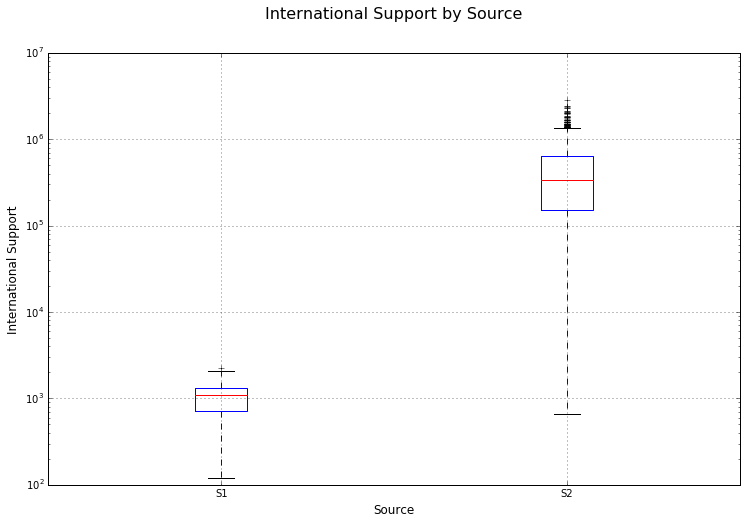

In [44]:
# Create a figure
fig = plt.figure(figsize=(12,8))

# Add a subplot
ax = fig.add_subplot(111)

# Show the International Support data by source
#bp = IntSupp[IntSupp.InternationalSupport != 0].boxplot('InternationalSupport', by='Source', ax=ax, return_type="axes")
bp = IntSupp.boxplot('InternationalSupport', by='Source', ax=ax, return_type="axes")

# Set the title and axis labels
fig.suptitle('International Support by Source', fontsize=16)
ax.set_title("")
ax.set_xlabel("Source", fontsize=12)
ax.set_ylabel("International Support", fontsize=12)
ax.set_yscale('log')

plt.show()

These are clearly different by at least a couple of orders of magnitude. Is there any correlation between the values?

Create a scatter-plot of matching data from the two sources

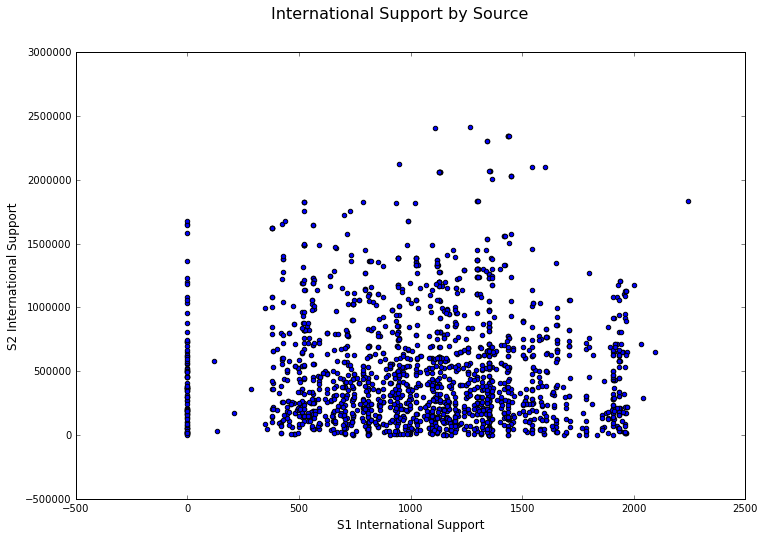

In [45]:
# Combine equivalent S1 and S2 records
IntSupp = IntSupp1.merge(IntSupp2, how = "inner", on = ["Year","CountryName","DisasterType","DisasterSubtype"])

# Create a figure
fig = plt.figure(figsize=(12,8))

# Add a subplot
ax = fig.add_subplot(111)

# Scatter plot of International Support for matching S1 and S2 records
sp = IntSupp.plot.scatter("InternationalSupport_x","InternationalSupport_y", ax=ax) 

# Set the title and axis labels
fig.suptitle('International Support by Source', fontsize=16)
ax.set_title("")
ax.set_xlabel("S1 International Support", fontsize=12)
ax.set_ylabel("S2 International Support", fontsize=12)

plt.show()

There is no evidence of any correlation, so it appears that the International support columns in S1 and S2 represent different attributes.

Have a closer look at S1."International support". What range of values are there for each disaster type?

In [46]:
# Display distinct values of International support by Type
S1.groupby(["Type","International support"])["Type"].count()

Type        International support
Drought     0.000                     1
            1096.777                  1
            1513.648                  1
            1799.146                  1
            2801.093                  1
Earthquake  0.000                    20
            518.622                   1
            518.623                   2
            518.625                   2
            518.636                   1
            518.686                   1
            518.697                   1
            518.705                   1
            518.717                   1
            519.102                   1
            519.106                   1
            519.922                   1
            524.383                   1
            552.599                   1
            552.608                   1
            556.629                   1
            556.630                   1
            556.652                   1
            556.695                   1
      

There appears to be several ranges of very close groups of values for each disaster type. Plot the ranges for a couple of countries to see whether there are any patterns. Australia and Canada are fairly similar in terms of size, population and wealth, so should receive similar assistance for similar disasters.

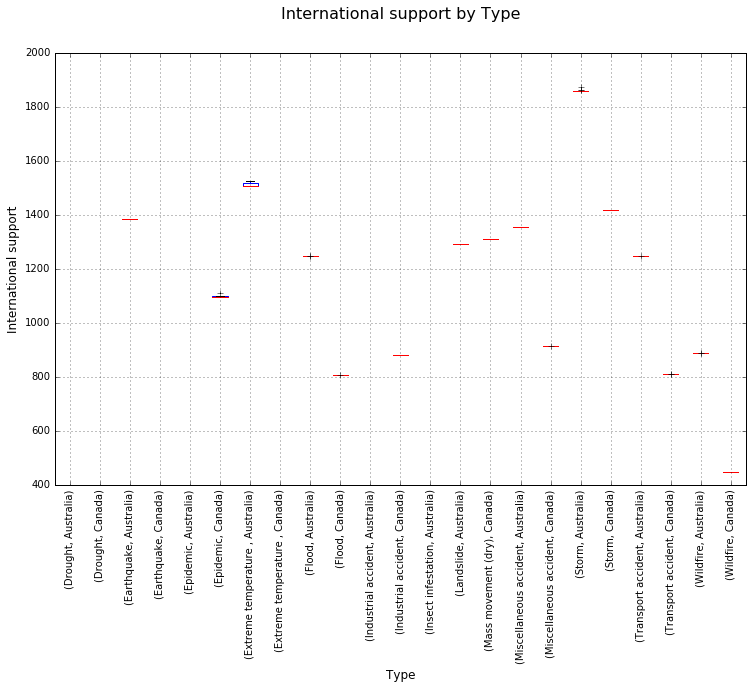

In [47]:
# Create a figure
fig = plt.figure(figsize=(12,8))

# Add a subplot
ax = fig.add_subplot(111)

# Show the International Support data by source
bp = S1[(S1["International support"] != 0) & (S1.Country.isin(["Australia","Canada"]))].boxplot('International support', by=["Type","Country"], ax=ax, rot=90, return_type="axes")
#bp = S1[(S1["International support"] != 0)].boxplot('International support', by=["Type",'Sub_Type'], ax=ax, rot=90, return_type="axes")

# Set the title and axis labels
fig.suptitle('International support by Type', fontsize=16)
ax.set_title("")
ax.set_xlabel("Type", fontsize=12)
ax.set_ylabel("International support", fontsize=12)

plt.show()

Australia consistently receives more support than Canada. Are Australia's disasters a lot worse than Canada's, or does the international community just like us better?

What difference is there in the support for a couple of disaster types across all countries?

In [48]:
# Extract International support values for Flood
T1 = S1[(S1["International support"] > 0) & (S1.Type == "Flood")].groupby(["Country"])["International support"]. \
     min().reset_index().sort_values("International support")
# Extract International support values for Storm    
T2 = S1[(S1["International support"] > 0) & (S1.Type == "Storm")].groupby(["Country"])["International support"]. \
     min().reset_index().sort_values("International support")
# Merge the data
T3 = T1.merge(T2, how="inner", on="Country", suffixes=["_Flood", "_Storm"])
# Find the different between the two International support values
T3["diff"] = (T3["International support_Storm"] - T3["International support_Flood"]).apply(round)
# Display the results
print "Difference in support for floods and storms - min: {0}, mean: {1}, max: {2}". \
     format(T3["diff"].min(), T3["diff"].mean(), T3["diff"].max(),)
T3

Difference in support for floods and storms - min: 611.0, mean: 612.098901099, max: 614.0


,Country,International support_Flood,International support_Storm,diff
0,Guinea-Bissau,377.142,989.555,612.000
1,Pakistan,380.276,992.673,612.000
2,Belarus,384.708,997.227,613.000
3,Costa Rica,418.288,1030.686,612.000
4,Nepal,425.940,1038.331,612.000
5,North Korea,428.106,1040.455,612.000
6,Bolivia,446.309,1058.782,612.000
7,Papua New Guinea,455.716,1068.146,612.000
8,Russia,479.240,1091.636,612.000
9,Germany,495.500,1107.266,612.000


Remarkable - The difference in the minimum support received for floods and storms in each country is almost the same! And what has poor Guinea-Bissau done to receive so little support?

Also note that Nepal (row 4) received about 53 less support than Russia (row 8) for both floods and storms, and Indonesia (row 70) about 130 less than Australia (row 79).

Try another pair of disasters

In [49]:
# Extract International support values for Wildfire
T1 = S1[(S1["International support"] > 0) & (S1.Type == "Wildfire")].groupby(["Country"])["International support"]. \
     min().reset_index().sort_values("International support")
# Extract International support values for Earthquake    
T2 = S1[(S1["International support"] > 0) & (S1.Type == "Earthquake")].groupby(["Country"])["International support"]. \
     min().reset_index().sort_values("International support")
# Merge the data
T3 = T1.merge(T2, how="inner", on="Country", suffixes=["_Wildfire", "_Earthquake"])
# Find the different between the two International support values
T3["diff"] = (T3["International support_Earthquake"] - T3["International support_Wildfire"]).apply(round)
# Display the results
print "Difference in support for wildfires and earthquakes - min: {0}, mean: {1}, max: {2}". \
     format(T3["diff"].min(), T3["diff"].mean(), T3["diff"].max(),)
T3

Difference in support for wildfires and earthquakes - min: 497.0, mean: 497.0, max: 497.0


,Country,International support_Wildfire,International support_Earthquake,diff
0,Nepal,67.440,564.408,497.000
1,Russia,120.723,617.595,497.000
2,France,208.082,704.948,497.000
3,Chile,231.201,728.065,497.000
4,Turkey,356.826,853.689,497.000
5,United States,382.057,878.922,497.000
6,Bulgaria,409.610,906.477,497.000
7,South Africa,463.662,960.527,497.000
8,Greece,484.040,980.905,497.000
9,Italy,580.817,1077.684,497.000


A similar pattern here - Nepal's the unlucky country in this case. Australia's the lucky country. Well although we like to think this, there is no luck involved here.

Again Nepal (row 0) received about 53 less support than Russia (row 1) for both wildfires and earthquakes, and Indonesia (row 11) about 130 less than Australia (row 12).

These values have nothing to do with actual international support provided - they look like they are generated from some function applied to the Country and Type (with some random variation so it's not too obvious). Something designed to frustrate poor long-suffering FIT5196 students perhaps?

Check S2 to see if there is a similar problem with this data:

In [50]:
# Extract International support values for Flood
T1 = S2[(S2["International support"] > 0) & (S2["disaster type"] == "Flood")]. \
     groupby(["Country name","disaster type"])["International support"].min().reset_index().sort_values("International support")
# Extract International support values for Storm    
T2 = S2[(S2["International support"] > 0) & (S2["disaster type"] == "Storm")]. \
     groupby(["Country name","disaster type"])["International support"].min().reset_index().sort_values("International support")
# Merge the data
T3 = T1.merge(T2, how="inner", on="Country name", suffixes=["_Flood", "_Storm"])
# Find the different between the two International support values
T3["diff"] = (T3["International support_Storm"] - T3["International support_Flood"]).apply(round)
# Display the results
print "Difference in support for floods and storms - min: {0}, mean: {1}, max: {2}". \
     format(T3["diff"].min(), T3["diff"].mean(), T3["diff"].max(),)
T3

Difference in support for floods and storms - min: -462834.0, mean: 68739.0458716, max: 1094788.0


,Country name,disaster type_Flood,International support_Flood,disaster type_Storm,International support_Storm,diff
0,France,Flood,220.300,Storm,36311.530,36091.000
1,United States of America (the),Flood,2138.820,Storm,7714.330,5576.000
2,Slovenia,Flood,2259.790,Storm,146614.760,144355.000
3,Somalia,Flood,2400.000,Storm,950125.100,947725.000
4,Russian Federation (the),Flood,3576.690,Storm,100609.360,97033.000
5,Algeria,Flood,3725.260,Storm,273459.040,269734.000
6,Burundi,Flood,4478.710,Storm,402663.630,398185.000
7,Honduras,Flood,5154.500,Storm,10801.780,5647.000
8,Colombia,Flood,5426.820,Storm,140513.310,135086.000
9,Dominican Republic (the),Flood,5877.990,Storm,134742.180,128864.000


These figures look much more realistic!

As S1."International support" and S2."International support" do not represent the same attribute, International support" cannot be included in the global schema.

#### Conflicting Attribute Names

Different names for the same attribute in S1 and S2 will be resolved when defining the global schema (SD) and the semantic mapping from S1 and S2 to SD.

The issue to resolve here is S2 has two attributes with similar names - "Affected" and "Total affected". Investigate the difference between the S2 attributes "Affected" and "Total affected".

S2 has attributes "Total deaths", "Affected", "Injured", "Homeless" and "Total affected". A possible relationship between these attributes is that "Total Affected" is the sum of "Affected", "Injured", "Homeless" and maybe "Total deaths". Check to see if this is the case.

In [51]:
# List any records where "Total affected" is not the sum of "Affected", "Injured" and "Homeless"
print S2.loc[S2["Total affected"] != S2["Affected"] + S2["Injured"] + S2["Homeless"],]

Empty DataFrame
Columns: [year, disaster type, Country iso, Country name, disaster group, disaster subgroup, disaster subtype, continent, region, occurrence, Total deaths, Affected, Injured, Homeless, Total affected, Total damage, International support, ISO3166A3, ISOen_name]
Index: []


So "Total Affected" is the sum of "Affected", "Injured" and "Homeless".

The question of whether S1.Affected matches to S2.Affected or S2."Total affected" will be resolved when merging the data

#### Data Aggregation Level

S2 has a column called "Occurrence" which has values between 1 and 17. This could be a sequence number to make a combination of values unique, or it could indicate that the S2 data has been aggregated and the value of occurrence is the number of disasters the record represents.

1\. Look at records with a high value for occurrence

In [52]:
S2[S2.occurrence >= 12]

,year,disaster type,Country iso,Country name,disaster group,disaster subgroup,disaster subtype,continent,region,occurrence,Total deaths,Affected,Injured,Homeless,Total affected,Total damage,International support,ISO3166A3,ISOen_name
657,2001,Storm,USA,United States of America (the),Natural,Meteorological,Convective storm,Americas,Northern America,12,17,7184,149,1198,8531,328800,155712.180,USA,United States
1771,2005,Flood,IND,India,Natural,Hydrological,Riverine flood,Asia,Southern Asia,16,2102,27225000,71,256500,27481571,6190000,151229.230,IND,India
2056,2006,Flood,CHN,China,Natural,Hydrological,Riverine flood,Asia,Eastern Asia,17,330,14610500,549,367000,14978049,1546500,294619.470,CHN,China
2078,2006,Flood,IND,India,Natural,Hydrological,Riverine flood,Asia,Southern Asia,14,1116,3219000,178,4000000,7219178,3390000,824249.910,IND,India
2359,2007,Flood,IND,India,Natural,Hydrological,Riverine flood,Asia,Southern Asia,13,1804,30743000,0,0,30743000,101151,1493759.960,IND,India
3027,2009,Storm,PHL,Philippines (the),Natural,Meteorological,Tropical cyclone,Asia,South-Eastern Asia,13,1242,12220696,867,0,12221563,932698,297258.760,PHL,Philippines
3554,2011,Storm,PHL,Philippines (the),Natural,Meteorological,Tropical cyclone,Asia,South-Eastern Asia,12,1782,9462385,6291,0,9468676,527238,869594.830,PHL,Philippines
3692,2012,Flood,CHN,China,Natural,Hydrological,Riverine flood,Asia,Eastern Asia,12,622,32992000,0,0,32992000,14970333,1820710.800,CHN,China
3893,2013,Flood,CHN,China,Natural,Hydrological,Riverine flood,Asia,Eastern Asia,14,637,7594000,30,90000,7684030,16598600,1581604.890,CHN,China


2\. Compare S2.occurrence for USA disasters in 2001 with the counts of equivalent records in S1

In [53]:
S2.loc[(S2.year == 2001) & (S2["Country iso"] == "USA"),]. \
    groupby(["disaster type","disaster subtype"])["occurrence"].sum()

disaster type         disaster subtype
Earthquake            Ground movement      1
Extreme temperature   Heat wave            1
Flood                 --                   1
                      Riverine flood       4
Storm                 --                   3
                      Convective storm    13
                      Tropical cyclone     1
Wildfire              Forest fire          3
Name: occurrence, dtype: int64

In [54]:
S1.loc[(S1.Start.apply(lambda x: x.year) == 2001) & (S1.Country == "United States") & \
       (~ S1.Type.isin(["Industrial accident","Miscellaneous accident","Transport accident"])),]. \
    groupby(["Type","Sub_Type"])["Start"].count()

Type                  Sub_Type        
Earthquake            Ground movement      1
Extreme temperature   Heat wave            1
Flood                 --                   1
                      Riverine flood       4
Storm                 --                   3
                      Convective storm    13
                      Tropical cyclone     1
Wildfire              Forest fire          3
Name: Start, dtype: int64

From 1, S2.occurrence doesn't appear to be a sequence number as there is no record with occurrence=15, and the only records for 16 and 17 are for different countries in different years.

From 2, Comparing the S1 and S2 records for the USA in 2001 (and ignoring the non-natural disasters) shows a close match between the sum of S2.occurrence and the count of records in S1.

Therefore records in S2 are aggregated and S2.occurrence indicates the aggregated number of disasters.

S1 records therefore need to be aggregated by Year, Country, Type and Sub_Type to match.

### Step 2: Merging

#### Global Schema

The table below shows the global schema attributes and the semantic mapping from S1 and S2.

 Attribute            | S1 source                             | S2 source
 ---------------------|---------------------------------------|----------------------
 Year                 | Year (derived)                        | year
 CountryName          | ISOen_Name (derived)                  | ISOen_Name (derived)
 CountryISO           | ISO3166A3 (derived)                   | ISO3166A3 (derived) 
 Continent            | Continent (derived)                   | continent
 Region               | Region (derived)                      | region
 DisasterSubgroup     | Subgroup (derived)                    | Disaster subgroup
 DisasterType         | Type (standardised to S2 values)      | Disaster type
 DisasterSubtype      | Sub_Type (standardised to S2 values)  | Disaster subtype
 Occurrence           | Count of aggregated data (to be done) | occurrence
 TotalDeaths          | Killed                                | Total deaths
 TotalAffected        | Affected                              | Affected/Total affected (still to be resolved)
 

#### Prepare S1 for Merging 

Display S1 attributes

In [55]:
S1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13694 entries, 0 to 13693
Data columns (total 16 columns):
Start                    13694 non-null datetime64[ns]
End                      13694 non-null datetime64[ns]
Country                  13694 non-null object
Location                 12020 non-null object
Type                     13694 non-null object
Sub_Type                 13694 non-null object
Names                    4444 non-null object
Killed                   11098 non-null float64
Affected                 8517 non-null float64
International support    6838 non-null float64
Year                     13694 non-null int64
Subgroup                 13694 non-null object
ISO3166A3                13694 non-null object
ISOen_name               13694 non-null object
continent                13694 non-null object
region                   13694 non-null object
dtypes: datetime64[ns](2), float64(3), int64(1), object(10)
memory usage: 1.8+ MB


##### Check S1 for Duplicates

Define a duplicate as records that meet the following criteria:
- match on "Start", "End", "ISO3166A3", "Location", "Type", "Sub_Type", "Names" and either "Killed" or "Affected"
- and have a value for at least one of "Location", "Sub_Type" or "Names"

In [56]:
# Extract the duplicates
S1dups = pd.concat([S1.loc[(~pd.isnull(S1.Location) | ~pd.isnull(S1.Names) | (S1.Sub_Type != "--")) & 
                           S1[["Start", "End", "ISO3166A3", "Location",
                               "Type", "Sub_Type", "Names", "Killed"]].duplicated(keep=False),],
                    S1.loc[(~pd.isnull(S1.Location) | ~pd.isnull(S1.Names) | (S1.Sub_Type != "--")) & 
                           S1[["Start", "End", "ISO3166A3", "Location",
                               "Type", "Sub_Type", "Names", "Affected"]].duplicated(keep=False),]]). \
    reset_index().drop_duplicates("index").sort_values(["ISO3166A3", "Start", "Killed", "Affected"])
    
# Display the duplicates    
S1dups    

,index,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,International support,Year,Subgroup,ISO3166A3,ISOen_name,continent,region
6,7556,1956-03-01,1956-03-01,Brazil,NaN,Landslide,Landslide,NaN,30.000,nan,nan,1956,Hydrological,BRA,Brazil,Americas,South America
7,10085,1956-03-01,1956-03-01,Brazil,NaN,Landslide,Landslide,NaN,36.000,nan,nan,1956,Hydrological,BRA,Brazil,Americas,South America
0,6243,1994-05-01,1994-05-01,Brazil,Sao Paulo,Storm,Convective storm,NaN,nan,1000.000,nan,1994,Meteorological,BRA,Brazil,Americas,South America
1,10431,1994-05-01,1994-05-01,Brazil,Sao Paulo,Storm,Convective storm,NaN,nan,1000.000,nan,1994,Meteorological,BRA,Brazil,Americas,South America
2,11887,1980-04-01,1980-04-01,Spain,NaN,Transport accident,Air,NaN,146.000,nan,nan,1980,Technological,ESP,Spain,Europe,Southern Europe
3,11936,1980-04-01,1980-04-01,Canary Is,NaN,Transport accident,Air,NaN,146.000,nan,nan,1980,Technological,ESP,Spain,Europe,Southern Europe
8,10097,1943-06-01,1943-06-01,Sudan,Khartoum,Transport accident,Air,Lockheed Hudson VI,16.000,nan,nan,1943,Technological,SDN,Sudan,Africa,Northern Africa
4,6190,1943-06-01,1943-06-01,Sudan,Khartoum,Transport accident,Air,Lockheed Hudson VI,17.000,nan,nan,1943,Technological,SDN,Sudan,Africa,Northern Africa


Four pairs of duplicates have been found - drop one of each pair

In [57]:
# Drop the duplicates
S1.drop(S1dups.drop_duplicates(["ISOen_name","Type"])["index"], inplace=True)

# Check the results
S1.merge(pd.DataFrame(S1dups["index"]), left_index=True, right_on="index")

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,International support,Year,Subgroup,ISO3166A3,ISOen_name,continent,region,index
4,1943-06-01,1943-06-01,Sudan,Khartoum,Transport accident,Air,Lockheed Hudson VI,17.000,nan,nan,1943,Technological,SDN,Sudan,Africa,Northern Africa,6190
7,1956-03-01,1956-03-01,Brazil,NaN,Landslide,Landslide,NaN,36.000,nan,nan,1956,Hydrological,BRA,Brazil,Americas,South America,10085
1,1994-05-01,1994-05-01,Brazil,Sao Paulo,Storm,Convective storm,NaN,nan,1000.000,nan,1994,Meteorological,BRA,Brazil,Americas,South America,10431
3,1980-04-01,1980-04-01,Canary Is,NaN,Transport accident,Air,NaN,146.000,nan,nan,1980,Technological,ESP,Spain,Europe,Southern Europe,11936


##### Aggregate S1 Data

In [58]:
# Aggregate the data
S1group = S1.groupby(["Year", "ISOen_name", "ISO3166A3", "continent", "region",
                      "Subgroup", "Type", "Sub_Type"]).agg({"Start": "count",
                                                            "Killed": "sum",
                                                            "Affected": "sum"}).reset_index()

# Add in the extra columns
S1group["Source"] = "S1"

# Rename the columns
S1group.columns = ["Year", "CountryName", "CountryISO", "Continent", "Region", "DisasterSubgroup", "DisasterType",
                  "DisasterSubtype", "Occurrence", "Affected", "TotalDeaths", "Source"]

# Re-arrange into the desired order
S1group = S1group[["Year", "CountryName", "CountryISO", "Continent", "Region", "DisasterSubgroup", "DisasterType",
                   "DisasterSubtype", "Occurrence", "TotalDeaths", "Affected", "Source"]]

# Check the results
S1group[S1group.Occurrence > 1].head()

,Year,CountryName,CountryISO,Continent,Region,DisasterSubgroup,DisasterType,DisasterSubtype,Occurrence,TotalDeaths,Affected,Source
7,1902,Guatemala,GTM,Americas,Central America,Geophysical,Volcanic activity,Volcanic eruption,2,7000.000,nan,S1
22,1906,Belgium,BEL,Europe,Western Europe,Hydrological,Flood,--,2,6.000,nan,S1
109,1917,Netherlands,NLD,Europe,Western Europe,Technological,Transport accident,Air,2,45.000,nan,S1
184,1927,India,IND,Asia,Southern Asia,Meteorological,Storm,Tropical cyclone,2,685.000,40010.000,S1
203,1929,Belgium,BEL,Europe,Western Europe,Technological,Industrial accident,Explosion,2,38.000,20.000,S1


#### Prepare S2 for Merging

Display S2 attributes

In [59]:
S2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4503 entries, 0 to 4502
Data columns (total 19 columns):
year                     4503 non-null int64
disaster type            4503 non-null object
Country iso              4503 non-null object
Country name             4503 non-null object
disaster group           4503 non-null object
disaster subgroup        4503 non-null object
disaster subtype         4503 non-null object
continent                4503 non-null object
region                   4503 non-null object
occurrence               4503 non-null int64
Total deaths             4503 non-null int64
Affected                 4503 non-null int64
Injured                  4503 non-null int64
Homeless                 4503 non-null int64
Total affected           4503 non-null int64
Total damage             4503 non-null int64
International support    4503 non-null float64
ISO3166A3                4503 non-null object
ISOen_name               4503 non-null object
dtypes: float64(1), int64(

##### Check and Fix S2 Aggregation

Check to see if the data is aggregated at the correct level

In [60]:
S2[S2.duplicated(["year","ISO3166A3","disaster type","disaster subtype"], keep=False)]

,year,disaster type,Country iso,Country name,disaster group,disaster subgroup,disaster subtype,continent,region,occurrence,Total deaths,Affected,Injured,Homeless,Total affected,Total damage,International support,ISO3166A3,ISOen_name
267,2000,Landslide,ECU,Ecuador,Natural,Hydrological,Landslide,Americas,South America,1,14,0,25,180,205,0,390130.160,ECU,Ecuador
268,2000,Landslide,ECU,Ecuador,Natural,Hydrological,Landslide,Americas,South America,1,30,150,30,0,180,0,996654.540,ECU,Ecuador
272,2000,Landslide,IDN,Indonesia,Natural,Hydrological,Landslide,Asia,South-Eastern Asia,2,52,0,19,520,539,0,987915.480,IDN,Indonesia
273,2000,Landslide,IDN,Indonesia,Natural,Hydrological,Landslide,Asia,South-Eastern Asia,2,74,54085,0,2125,56210,54600,1152145.090,IDN,Indonesia
283,2000,Storm,ARG,Argentina,Natural,Meteorological,Convective storm,Americas,South America,1,1,0,0,430,430,0,56980.950,ARG,Argentina
284,2000,Storm,ARG,Argentina,Natural,Meteorological,Convective storm,Americas,South America,1,0,0,0,0,0,0,0.000,ARG,Argentina
335,2000,Storm,USA,United States of America (the),Natural,Meteorological,Convective storm,Americas,Northern America,1,12,0,75,0,75,500000,267101.490,USA,United States
336,2000,Storm,USA,United States of America (the),Natural,Meteorological,Convective storm,Americas,Northern America,1,0,0,0,0,0,0,0.000,USA,United States
337,2000,Storm,USA,United States of America (the),Natural,Meteorological,Convective storm,Americas,Northern America,6,30,4800,242,570,5612,786600,14962.800,USA,United States
338,2000,Storm,USA,United States of America (the),Natural,Meteorological,Convective storm,Americas,Northern America,1,0,0,0,0,0,0,0.000,USA,United States


There are a few records that are not aggregated at the correct level - maybe because the aggregation included an attribute that has been subsequently removed (for example - the EMDAT database has an additional subsubtype attribute which may have been used for aggregation).

Aggregate the S2 data on the required attributes, then add the Source column and rename attributes to global schema names

In [61]:
# Extract the required columns from S2 and aggregate
S2group = S2[["year", "ISOen_name", "ISO3166A3", "continent", "region", "disaster subgroup", "disaster type", "disaster subtype",
              "occurrence", "Total deaths", "Affected", "Total affected"]]. \
          groupby(["year", "ISOen_name", "ISO3166A3", "continent", "region",
                   "disaster subgroup", "disaster type", "disaster subtype"]).sum().reset_index()
S2group.head()    

,year,ISOen_name,ISO3166A3,continent,region,disaster subgroup,disaster type,disaster subtype,occurrence,Total deaths,Affected,Total affected
0,2000,Afghanistan,AFG,Asia,Southern Asia,Biological,Epidemic,--,1,15,613,613
1,2000,Afghanistan,AFG,Asia,Southern Asia,Biological,Epidemic,Bacterial disease,1,19,1604,1604
2,2000,Afghanistan,AFG,Asia,Southern Asia,Biological,Epidemic,Viral disease,2,523,11,11
3,2000,Afghanistan,AFG,Asia,Southern Asia,Climatological,Drought,Drought,1,37,2580000,2580000
4,2000,Afghanistan,AFG,Asia,Southern Asia,Geophysical,Earthquake,Ground movement,1,0,0,0


In [62]:
# Add the source
S2group["Source"] = "S2"

# Rename the columns
S2group.columns = ["Year", "CountryName", "CountryISO", "Continent", "Region",
                   "DisasterSubgroup", "DisasterType", "DisasterSubtype", "Occurrence", "TotalDeaths",
                   "Affected", "TotalAffected", "Source"]

# Check the results
S2group[S2group.Occurrence > 1].head()

,Year,CountryName,CountryISO,Continent,Region,DisasterSubgroup,DisasterType,DisasterSubtype,Occurrence,TotalDeaths,Affected,TotalAffected,Source
2,2000,Afghanistan,AFG,Asia,Southern Asia,Biological,Epidemic,Viral disease,2,523,11,11,S2
5,2000,Algeria,DZA,Africa,Northern Africa,Hydrological,Flood,--,2,7,0,100,S2
6,2000,Algeria,DZA,Africa,Northern Africa,Hydrological,Flood,Flash flood,2,37,100,105,S2
9,2000,Angola,AGO,Africa,Middle Africa,Hydrological,Flood,--,3,15,0,9011,S2
13,2000,Argentina,ARG,Americas,South America,Hydrological,Flood,--,3,6,30000,31840,S2


#### TotalAffected vs Affected Resolution

Does S1.Affected match S2.Affected or S2."Total Affected"?

Find matching records (matching on "Year", "CountryName", "DisasterType", "DisasterSubtype" and "Occurrence") in S1group and S2group and compare the various Affected attributes

In [63]:
# Extract and match the overlapping data
Afd = S2group[["Year", "CountryName", "DisasterType", "DisasterSubtype", "Affected", "TotalAffected", "Occurrence"]]. \
           merge(S1group[["Year", "CountryName", "DisasterType", "DisasterSubtype", "Affected", "Occurrence"]],
                 on = ["Year", "CountryName", "DisasterType", "DisasterSubtype", "Occurrence"])
# Count the records where the S2 Affected and TotalAffected values do not match    
afdcnt = Afd.loc[(Afd.Affected_x != Afd.TotalAffected), "Year"].count()
# Count the records where S1 Affected matches S2 Affected but not S2 TotalAffected
afd1 = Afd.loc[(Afd.Affected_x != Afd.TotalAffected) & (Afd.Affected_x == Afd.Affected_y), "Affected_x"].count()  
# Count the records where S1 Affected matches S2 TotalAffected but not S2 Affected
afd2 = Afd.loc[(Afd.Affected_x != Afd.TotalAffected) & (Afd.TotalAffected == Afd.Affected_y), "TotalAffected"].count()
print "There are {0} records in S2group that have different values for Affected and TotalAffected".format(afdcnt) + \
      " and match to a record in S1.\nOf these there are:"
print "- {0} records where S1group.Affected matches S2group.Affected".format(afd1)
print "- {0} records where S1group.Affected matches S2group.TotalAffected".format(afd2)

There are 657 records in S2group that have different values for Affected and TotalAffected and match to a record in S1.
Of these there are:
- 0 records where S1group.Affected matches S2group.Affected
- 651 records where S1group.Affected matches S2group.TotalAffected


From the above it is clear that the Affected attribute in S1 corresponds to the TotalAffected attribute in S2. Fix S1group and S2group appropriately.

In [64]:
# Drop Affected from S2group
S2group.drop("Affected", axis=1, inplace=True)
# Rename Affected to TotalAffected in S1group
S1group.rename(columns={"Affected":"TotalAffected"}, inplace=True)

#### Merge S1 and S2

In [65]:
# Check the dataframes match
S1group[["Year", "CountryName", "CountryISO", "Continent", "Region", "DisasterSubgroup",
         "DisasterType", "DisasterSubtype", "Occurrence", "TotalDeaths", "TotalAffected", "Source"]].info()
S2group[["Year", "CountryName", "CountryISO", "Continent", "Region", "DisasterSubgroup",
         "DisasterType", "DisasterSubtype", "Occurrence", "TotalDeaths", "TotalAffected", "Source"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9806 entries, 0 to 9805
Data columns (total 12 columns):
Year                9806 non-null int64
CountryName         9806 non-null object
CountryISO          9806 non-null object
Continent           9806 non-null object
Region              9806 non-null object
DisasterSubgroup    9806 non-null object
DisasterType        9806 non-null object
DisasterSubtype     9806 non-null object
Occurrence          9806 non-null int64
TotalDeaths         7976 non-null float64
TotalAffected       6356 non-null float64
Source              9806 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 919.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4407 entries, 0 to 4406
Data columns (total 12 columns):
Year                4407 non-null int64
CountryName         4407 non-null object
CountryISO          4407 non-null object
Continent           4407 non-null object
Region              4407 non-null object
DisasterSubgroup    4407 n

In [66]:
# Merge the dataframes
SD = S1group.append(S2group, ignore_index=True)[["Year", "CountryName", "CountryISO", "Continent", "Region", "DisasterSubgroup",
                                                 "DisasterType", "DisasterSubtype", "Occurrence", "TotalDeaths",
                                                 "TotalAffected", "Source"]]
# Display the first few records
SD.head()

,Year,CountryName,CountryISO,Continent,Region,DisasterSubgroup,DisasterType,DisasterSubtype,Occurrence,TotalDeaths,TotalAffected,Source
0,1900,Jamaica,JAM,Americas,Caribbean,Biological,Epidemic,Viral disease,1,30.000,nan,S1
1,1900,Japan,JPN,Asia,Eastern Asia,Geophysical,Volcanic activity,Volcanic eruption,1,30.000,nan,S1
2,1900,United States,USA,Americas,Northern America,Meteorological,Storm,Tropical cyclone,1,6000.000,nan,S1
3,1900,United States,USA,Americas,Northern America,Technological,Miscellaneous accident,Fire,1,300.000,nan,S1
4,1901,Belgium,BEL,Europe,Western Europe,Technological,Industrial accident,Explosion,1,18.000,nan,S1


In [67]:
# Display the last few records
SD.tail()

,Year,CountryName,CountryISO,Continent,Region,DisasterSubgroup,DisasterType,DisasterSubtype,Occurrence,TotalDeaths,TotalAffected,Source
14208,2015,Yemen,YEM,Asia,Western Asia,Biological,Epidemic,Viral disease,1,3.000,3026.000,S2
14209,2015,Yemen,YEM,Asia,Western Asia,Meteorological,Storm,Tropical cyclone,2,32.000,125065.000,S2
14210,2015,Zimbabwe,ZWE,Africa,Eastern Africa,Biological,Epidemic,Bacterial disease,1,0.000,11.000,S2
14211,2015,Zimbabwe,ZWE,Africa,Eastern Africa,Climatological,Drought,Drought,1,0.000,1490024.000,S2
14212,2015,Zimbabwe,ZWE,Africa,Eastern Africa,Meteorological,Storm,Convective storm,1,10.000,475.000,S2


### Step 3: Data Conflicts

#### Detect and Resolve Inconsistencies

##### Missing Values

The info displays above show a few NaNs in the data from S1. Convert these to 0 so missing values are consistently represented. Change the TotalDeaths and Total Affected attributes to integers

In [68]:
# Update NaNs in TotalDeaths to 0
SD.loc[SD.TotalDeaths.isnull(),"TotalDeaths"] = 0
# Convert TotalDeaths to integer
SD["TotalDeaths"] = SD.TotalDeaths.astype("int64")
# Update NaNs in TotalAffected to 0
SD.loc[SD.TotalAffected.isnull(),"TotalAffected"] = 0
# Convert TotalAffected to integer
SD["TotalAffected"] = SD.TotalAffected.astype("int64")

# Check there are no more NaNs
SD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14213 entries, 0 to 14212
Data columns (total 12 columns):
Year                14213 non-null int64
CountryName         14213 non-null object
CountryISO          14213 non-null object
Continent           14213 non-null object
Region              14213 non-null object
DisasterSubgroup    14213 non-null object
DisasterType        14213 non-null object
DisasterSubtype     14213 non-null object
Occurrence          14213 non-null int64
TotalDeaths         14213 non-null int64
TotalAffected       14213 non-null int64
Source              14213 non-null object
dtypes: int64(4), object(8)
memory usage: 1.3+ MB


Most of the attributes have been inspected previously, but TotalDeaths and TotalAffected haven't been examined that closely.

First, plot boxplots of TotalDeaths and TotalAffected by source to see if these are consistent between sources

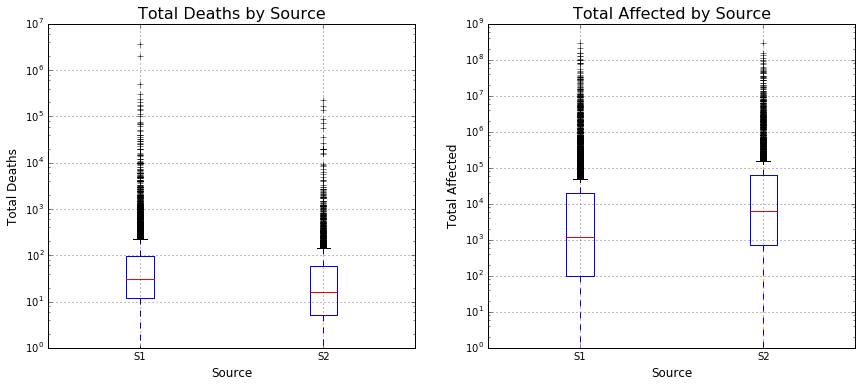

In [69]:
# Create a figure
fig = plt.figure(figsize=(14,6))

# Add the first subplot
ax = fig.add_subplot(121)

# Show the International Support data by source
bp = SD[SD.TotalDeaths != 0].boxplot('TotalDeaths', by='Source', ax=ax, return_type="axes")

# Set the title and axis labels
ax.set_title("Total Deaths by Source", fontsize=16)
ax.set_xlabel("Source", fontsize=12)
ax.set_ylabel("Total Deaths", fontsize=12)
ax.set_yscale('log')

# Add the second subplot
ax = fig.add_subplot(122)

# Show the International Support data by source
bp = SD[SD.TotalAffected != 0].boxplot('TotalAffected', by='Source', ax=ax, return_type="axes")

# Set the title and axis labels
ax.set_title("Total Affected by Source", fontsize=16)
ax.set_xlabel("Source", fontsize=12)
ax.set_ylabel("Total Affected", fontsize=12)
ax.set_yscale('log')

# Clear the figure title
fig.suptitle("", fontsize=16)

# Display the figure
plt.show(fig)

These look consistent - so no hidden surprises here!

#### Detect and Resolve Duplication

The preparation of the data before merging ensured there were no duplicates in S1 and none in S2. But there should be quite a few duplicates between the S1 and S2 data, as these both contained the data for 2000-2008. So these duplicates need to be removed.

In [70]:
# Find the duplicates based on all attributes apart from TotalDamages, InternationalSupport and Source
SD.loc[SD.duplicated(["Year", "CountryISO", "DisasterType", "DisasterSubtype",
                      "Occurrence", "TotalDeaths", "TotalAffected"], keep="last")]

,Year,CountryName,CountryISO,Continent,Region,DisasterSubgroup,DisasterType,DisasterSubtype,Occurrence,TotalDeaths,TotalAffected,Source
6265,2000,Afghanistan,AFG,Asia,Southern Asia,Biological,Epidemic,--,1,15,613,S1
6266,2000,Afghanistan,AFG,Asia,Southern Asia,Biological,Epidemic,Bacterial disease,1,19,1604,S1
6267,2000,Afghanistan,AFG,Asia,Southern Asia,Biological,Epidemic,Viral disease,2,523,11,S1
6268,2000,Algeria,DZA,Africa,Northern Africa,Hydrological,Flood,--,2,7,100,S1
6269,2000,Algeria,DZA,Africa,Northern Africa,Hydrological,Flood,Flash flood,2,37,105,S1
6270,2000,Algeria,DZA,Africa,Northern Africa,Meteorological,Storm,--,1,4,10,S1
6272,2000,Angola,AGO,Africa,Middle Africa,Biological,Epidemic,Bacterial disease,1,18,117,S1
6273,2000,Angola,AGO,Africa,Middle Africa,Hydrological,Flood,--,3,15,9011,S1
6274,2000,Angola,AGO,Africa,Middle Africa,Hydrological,Flood,Riverine flood,1,31,70000,S1
6275,2000,Angola,AGO,Africa,Middle Africa,Hydrological,Landslide,Landslide,1,13,0,S1


Drop the duplicate records, keeping the records from S2

In [71]:
# Drop the duplicate records, keeping the last record which is from S2 to keep the TotalDamage and InternationalSupport data
SD.drop_duplicates(["Year", "CountryISO", "DisasterType", "DisasterSubtype",
                    "Occurrence", "TotalDeaths", "TotalAffected"], keep="last", inplace=True)
SD.describe()

,Year,Occurrence,TotalDeaths,TotalAffected
count,12348.000,12348.000,12348.000,12348.000
mean,1993.775,1.455,893.217,525280.245
std,18.322,1.332,38579.576,6446349.353
min,1900.000,1.000,0.000,0.000
25%,1988.000,1.000,2.000,0.000
50%,1999.000,1.000,18.000,200.000
75%,2005.000,1.000,61.000,10000.000
max,2015.000,30.000,3700000.000,300000000.000


What other duplicates are there, based on "Year", "CountryISO", "DisasterType" and "DisasterSubtype"?

In [72]:
SD.loc[SD.duplicated(["Year", "CountryISO", "DisasterType", "DisasterSubtype"],keep=False),]. \
    sort_values(["Year", "CountryISO", "DisasterType", "DisasterSubtype"])

,Year,CountryName,CountryISO,Continent,Region,DisasterSubgroup,DisasterType,DisasterSubtype,Occurrence,TotalDeaths,TotalAffected,Source
2550,1985,Soviet Union,--,Europe,Eastern Europe,Geophysical,Earthquake,Ground movement,1,29,8080,S1
2578,1985,Yugoslavia,--,Europe,Southern Europe,Geophysical,Earthquake,Ground movement,1,0,1516,S1
3131,1988,Soviet Union,--,Europe,Eastern Europe,Technological,Transport accident,Rail,4,154,712,S1
3160,1988,Yugoslavia,--,Europe,Southern Europe,Technological,Transport accident,Rail,1,33,0,S1
3342,1989,Soviet Union,--,Europe,Eastern Europe,Technological,Transport accident,Rail,1,5,100,S1
3385,1989,Yugoslavia,--,Europe,Southern Europe,Technological,Transport accident,Rail,1,12,20,S1
3579,1990,Soviet Union,--,Europe,Eastern Europe,Geophysical,Earthquake,Ground movement,2,0,4508,S1
3637,1990,Yugoslavia,--,Europe,Southern Europe,Geophysical,Earthquake,Ground movement,1,8,120,S1
3582,1990,Soviet Union,--,Europe,Eastern Europe,Hydrological,Flood,Riverine flood,2,19,23000,S1
3638,1990,Yugoslavia,--,Europe,Southern Europe,Hydrological,Flood,Riverine flood,1,0,0,S1


As the records from each source have been aggregated based on "Year","CountryISO","DisasterType" and "DisasterSubtype", each remaining pair of duplicates must consist of a record from S1 and a record from S2, so are genuine duplicates. Keep the record that has the highest "Occurrence" as this record contains more information (summarizes more disasters).

In [73]:
SD.sort_values(["Year","CountryISO","DisasterType","DisasterSubtype","Occurrence","Source"], inplace=True)

In [74]:
SD.loc[[10145,10496,10727,10887,11105,11381],]

,Year,CountryName,CountryISO,Continent,Region,DisasterSubgroup,DisasterType,DisasterSubtype,Occurrence,TotalDeaths,TotalAffected,Source
10145,2000,United States,USA,Americas,Northern America,Meteorological,Extreme temperature,Heat wave,1,35,0,S2
10496,2002,Austria,AUT,Europe,Western Europe,Hydrological,Flood,Riverine flood,1,9,60000,S2
10727,2002,Philippines,PHL,Asia,South-Eastern Asia,Hydrological,Flood,Riverine flood,2,46,145008,S2
10887,2003,China,CHN,Asia,Eastern Asia,Meteorological,Storm,Tropical cyclone,3,58,9189945,S2
11105,2003,United States,USA,Americas,Northern America,Hydrological,Landslide,Landslide,1,15,15,S2
11381,2004,United States,USA,Americas,Northern America,Meteorological,Extreme temperature,Cold wave,1,3,0,S2


Now drop the duplicates. The TotalDamage and InternationalSupport data will be merged back into the SD dataset after the global key has been added, as matching back to the correct record will be simpler.

In [75]:
SD.drop_duplicates(["Year","CountryISO","DisasterType","DisasterSubtype"], keep="last", inplace=True)
SD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12033 entries, 0 to 14212
Data columns (total 12 columns):
Year                12033 non-null int64
CountryName         12033 non-null object
CountryISO          12033 non-null object
Continent           12033 non-null object
Region              12033 non-null object
DisasterSubgroup    12033 non-null object
DisasterType        12033 non-null object
DisasterSubtype     12033 non-null object
Occurrence          12033 non-null int64
TotalDeaths         12033 non-null int64
TotalAffected       12033 non-null int64
Source              12033 non-null object
dtypes: int64(4), object(8)
memory usage: 1.2+ MB


#### Add a Global Key

The attributes Year, CountryISO or CountryName, DisasterType and DisasterSubtype uniquely identify a record, so use a combination of these for the global key. Simply concatenating these attributes together makes a very long key, so CountryISO is used in preference to CountryName and DisasterType and DisasterSubtype will be abbreviated.

The global key will consist of the following components separated by underscores:
- Year
- Country ISO code
- First three characters of the Disaster Type
- First three characters of the Disaster Subtype

For example: 2000-USA-STO-EXT for the record for extra-tropical storms in the United States in the year 2000.

In [76]:
# Generate the global key values
SDkeys = SD.Year.map(str) + "_" + SD.CountryISO + "_" + \
         SD.DisasterType.str.upper().str.extract("^(...)") + "_" + \
         SD.DisasterSubtype.str.upper().str.extract("^(...?)").tolist()
# Set the index on the integrated dataframe         
SD.set_index(SDkeys, inplace=True, verify_integrity=True)
# Display the first few records to check
SD.head(10)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


,Year,CountryName,CountryISO,Continent,Region,DisasterSubgroup,DisasterType,DisasterSubtype,Occurrence,TotalDeaths,TotalAffected,Source
1900_JAM_EPI_VIR,1900,Jamaica,JAM,Americas,Caribbean,Biological,Epidemic,Viral disease,1,30,0,S1
1900_JPN_VOL_VOL,1900,Japan,JPN,Asia,Eastern Asia,Geophysical,Volcanic activity,Volcanic eruption,1,30,0,S1
1900_USA_MIS_FIR,1900,United States,USA,Americas,Northern America,Technological,Miscellaneous accident,Fire,1,300,0,S1
1900_USA_STO_TRO,1900,United States,USA,Americas,Northern America,Meteorological,Storm,Tropical cyclone,1,6000,0,S1
1901_BEL_IND_EXP,1901,Belgium,BEL,Europe,Western Europe,Technological,Industrial accident,Explosion,1,18,0,S1
1901_TZA_EAR_GRO,1901,"Tanzania, United Republic of",TZA,Africa,Eastern Africa,Geophysical,Earthquake,Ground movement,1,0,0,S1
1902_GTM_EAR_GRO,1902,Guatemala,GTM,Americas,Central America,Geophysical,Earthquake,Ground movement,1,2000,0,S1
1902_GTM_VOL_VOL,1902,Guatemala,GTM,Americas,Central America,Geophysical,Volcanic activity,Volcanic eruption,2,7000,0,S1
1902_JPN_VOL_VOL,1902,Japan,JPN,Asia,Eastern Asia,Geophysical,Volcanic activity,Volcanic eruption,1,125,0,S1
1902_MMR_STO_TRO,1902,Myanmar,MMR,Asia,South-Eastern Asia,Meteorological,Storm,Tropical cyclone,1,600,0,S1


### End of Task 1

Show a summary of the data frame attributes as at the end of task 1.

In [77]:
# Display the column data types
SD.dtypes

Year                 int64
CountryName         object
CountryISO          object
Continent           object
Region              object
DisasterSubgroup    object
DisasterType        object
DisasterSubtype     object
Occurrence           int64
TotalDeaths          int64
TotalAffected        int64
Source              object
dtype: object

In [78]:
# Describe the numeric values
SD.describe()

,Year,Occurrence,TotalDeaths,TotalAffected
count,12033.000,12033.000,12033.000,12033.000
mean,1993.516,1.433,907.220,478699.223
std,18.482,1.302,39075.482,6193766.759
min,1900.000,1.000,0.000,0.000
25%,1988.000,1.000,2.000,0.000
50%,1999.000,1.000,18.000,170.000
75%,2005.000,1.000,61.000,9127.000
max,2015.000,30.000,3700000.000,300000000.000


In [79]:
# Describe the non-numeric values
SD.describe(include=["object"])

,CountryName,CountryISO,Continent,Region,DisasterSubgroup,DisasterType,DisasterSubtype,Source
count,12033,12033,12033,12033,12033,12033,12033,12033
unique,216,214,5,22,8,17,42,2
top,India,IND,Asia,Southern Asia,Technological,Flood,--,S1
freq,514,514,4330,1472,3467,2812,1477,7632


### Write the Dataframe to a CSV File

In [80]:
# Write the integrated data to a CSV file
SD.to_csv("Disasters_data_integrated.csv")

## Mash up Map

In [81]:
sf = shapefile.Reader("world_countries_boundary_file_world_2002")
recs = sf.records()
shapes = sf.shapes()

Sample 80% of the integrated data and summarize the number of disasters from 1980 onwards by country.

In [82]:
# Sample 80% of the data
SM = SD.sample(frac=0.8)

# Extract data from 1980 on and summarise by country
SM_summ = pd.DataFrame(SM.loc[SM.Year>=1980,].groupby(["CountryISO","CountryName"])["Occurrence"].sum().astype("int64")). \
          reset_index()

# Check the result    
SM_summ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 3 columns):
CountryISO     216 non-null object
CountryName    216 non-null object
Occurrence     216 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.1+ KB


Generate bin boundaries using a slightly modified form of natural partitioning

In [83]:
# create bins boundaries using natural partitioning
qvals = SM_summ.Occurrence.quantile([0.05,0.95], interpolation="nearest") # Get the 5% and 95% quantiles
low = 20                                            # Set the low-point (adjustment to natural partitioning)
sig = 10.0**int(np.floor(math.log10(qvals[0.95])))  # Calculate msd position 
high = int(np.ceil(qvals[0.95]/sig)*sig)            # Set the high-point
intval = int(high-low)/3                            # Split the low-high range into third
mid1 = low + intval                                 # Set the lower tri-point
mid2 = high - intval                                # Set the upper tri-point

# create a set containing all the bin boundaries, then convert to list
bins = list({SM_summ.Occurrence.min(), low, mid1, mid2, high, SM_summ.Occurrence.max()+1})
bins.sort()                                         # Ensure the bin boundaries are sorted

# The number of colours the map will need - the number of bins plus one for "no data" 
nbins = len(bins)

# Labels for the bins
labels = range(1,nbins)

# Display the bin boundaries and labels
bins, labels

([1, 20, 80, 140, 200, 1011], [1, 2, 3, 4, 5])

In [84]:
# Label the summary data with the bin number
SM_summ["bin"]=pd.cut(SM_summ.Occurrence, bins, labels=labels, right=False)

# Check the number of records in each bin
SM_summ.bin.value_counts().sort_index()

1    96
2    83
3    16
4    12
5     9
Name: bin, dtype: int64

Plot the map - code is based on the code provided in tutorial 6

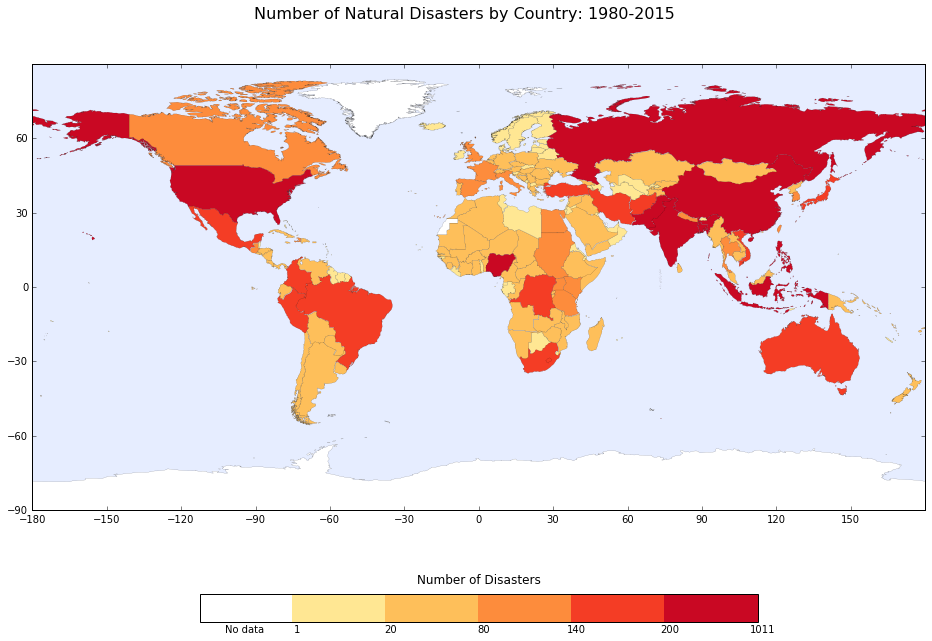

In [85]:
# Create the colour index
col=[]

# Match countries in the shapefile to the data and set the colour index
for c in range(len(recs)):
    col.append(SM_summ.loc[(SM_summ["CountryISO"] != "--") &
                           ((SM_summ["CountryISO"] == recs[c][1]) |
                            (SM_summ["CountryISO"] == recs[c][7]) |
                            (SM_summ["CountryName"] == recs[c][0])),"bin"])
    col[c] = int(col[c]) if len(col[c]) > 0 else 0

# Set the colours
#cm = matplotlib.cm.get_cmap('coolwarm')
cm = cmap.get_cmap('YlOrRd')
cccol = cm(1.*np.arange(nbins)/nbins)  # a colour for each bin
cccol[0] = [1.,1.,1.,1.]               # Countries with no disasters are white

# Create the plot
fig = plt.figure(figsize = (16,10))           # Plot size - allows for header and colour bar
fig.suptitle('Number of Natural Disasters by Country: 1980-2015', fontsize=16)
ax = fig.add_subplot(111)                     # Sub-plot position
ax.set_xlim(-180, +180)                       # Min/max longitudes
ax.xaxis.set_ticks(range(-180, +180, 30))     # Longitude intervals for x-axis
ax.set_ylim(-90, 90)                          # Min/max latitudes  
ax.yaxis.set_ticks(range(-90, +90, 30))       # Latitude intervals for y-axis
ax.patch.set_facecolor([0.9, 0.93, 1., 1.])   # Set background colour so oceans are pale blue

# Add each country and colour it
for nshp in xrange(len(shapes)):
    ptchs   = []
    pts     = np.array(shapes[nshp].points)
    prt     = shapes[nshp].parts
    par     = list(prt) + [pts.shape[0]]
        
    for pij in xrange(len(prt)):
         ptchs.append(Polygon(pts[par[pij]:par[pij+1]]))
    ax.add_collection(PatchCollection(ptchs,facecolor=cccol[col[nshp],:],edgecolor='k', linewidths=.1))

# Set up the colour bar
cb_col = plt.pcolor(cccol, cmap=ListedColormap(cccol), visible=False)
cbar = plt.colorbar(cb_col, orientation="horizontal", fraction=0.05, drawedges=True)
cbar.dividers.set_visible(False)
cbar.set_label("Number of Disasters", size=12)
cbar.ax.xaxis.set_label_coords(0.5, 1.75)
cbar.ax.get_xaxis().set_ticks([])
cbar.ax.text(0.08, -0.25, "No data", ha='center', va='center')
for bn, lab in enumerate(bins): 
    cbar.ax.text((bn+1.05)/nbins, -0.25, int(lab), ha='center', va='center')

# Plot the map    
plt.show()